# Week 8 - Semantic & Influence Networks

This week, we explore the representation and analysis of semantic networks. A word or document network is an unsupervized representation of text akin to a clustering or an embedding, but semantic networks can also be defined using semantic or syntactic information derived from methods we have used earlier in the quarter. For example, we can define links between words as a function of their co-presence within a document, chapter, paragraph, sentence, noun phrase or continuous bag of words. We can also define links as a function of words that rely on one another within a directed dependency parse, or links between extracted Subjects, Verbs and Objects, or nouns and the adjectives that modify them (or verbs and the adverbs that modify *them*). Rendering words linked as a network or discrete topology allows us to take advantage of the wide range of metrics and models developed for network analysis. These include measurement of network centrality, density and modularity, "block modeling" structurally equivalent relationships, and sophisticated graphical renderings of networks or network partitions that allow us to visually interrogate their structure and complexity.

For this notebook we will use the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import nltk #For POS tagging
import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats

import pickle #if you want to save layouts
import os

%matplotlib inline

# An Introduction to networks in *networkx*

We will primarily be dealing with graphs in this notebook, so lets first go over how to use them.

To start with lets create an undirected graph:

In [2]:
g = nx.Graph()
g

We can add nodes. These are all named, like entries in a dictionary.

In [3]:
g.add_node(1)
g.add_node(2)
g.add_node(3)

Now we have 3 vertices:

In [4]:
len(g.nodes)

3

Or if we want to get more information about the graph:

In [5]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 3
Number of edges: 0
Average degree:   0.0000


We can give nodes properties, like name or type

In [6]:
g.nodes[1]

{}

In [7]:
g.nodes[1]['type'] = 'NN'

In [8]:
g.nodes[1]

{'type': 'NN'}

In [9]:
g.nodes[2]['name'] = 'dog'

In [10]:
g.nodes[2]

{'name': 'dog'}

Still pretty boring...

Lets add a couple of edges. Notice that we use the ids, but not any of the properties:

In [11]:
g.add_edges_from([(1, 2), (2, 3), (3, 1), (1,4)])
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 4
Number of edges: 4
Average degree:   2.0000


Note how the summary has changed. Moreover, there's one additional node, because we asked for an edge to 4.

We can also give the edges properties like weights:

In [12]:
g.edges[1, 2]['weight'] = 2
g.edges[1, 4]['weight'] = 2
g.edges[1, 4]

{'weight': 2}

Let's visualize our graph now:

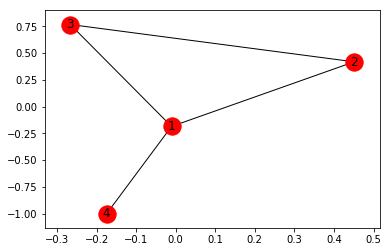

In [13]:
nx.draw_networkx(g)
plt.savefig("test.png")

Very exciting :-).

There are many things to do with the graph once we have created it, some of which we will explore here.

First let's load some data, like the Grimmer Senate press releases corpus:

In [14]:
senReleasesDF = pandas.read_csv('../data/senReleasesTraining.csv', index_col = 0)
senReleasesDF[:3]

download_url  \
0  https://raw.githubusercontent.com/lintool/Grim...   
1  https://raw.githubusercontent.com/lintool/Grim...   
2  https://raw.githubusercontent.com/lintool/Grim...   

                                            html_url                    name  \
0  https://github.com/lintool/GrimmerSenatePressR...  01Apr2005Kennedy14.txt   
1  https://github.com/lintool/GrimmerSenatePressR...  01Aug2005Kennedy12.txt   
2  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy10.txt   

                                 path  \
0  raw/Kennedy/01Apr2005Kennedy14.txt   
1  raw/Kennedy/01Aug2005Kennedy12.txt   
2  raw/Kennedy/01Aug2006Kennedy10.txt   

                                                text targetSenator  
0           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy  
1           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy  
2           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy

We will be extracting sentences, as well as tokenizing and stemming. (You should be able to do this in your sleep now).

In [15]:
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic) for s in x])

Let's begin by looking at words that co-occur in the same sentences:

In [16]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

First, build a graph based on word cooccurences in the first 100 press releases.

In [17]:
g = wordCooccurrence(senReleasesDF['normalized_sents'][:100].sum())

Total number of vertices:

In [18]:
len(g.nodes)

4270

Total number of edges:

In [19]:
len(g.edges)

2082420

A part of the adjacency matrix of cleaned word by press releases:

In [20]:
nx.to_numpy_matrix(g)[:5, :5]

matrix([[12.,  4.,  0.,  3.,  0.],
        [ 4.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 3.,  0.,  0.,  6.,  0.],
        [ 0.,  0.,  0.,  0.,  6.]])

We can save the graph and read it later, although this is slow if there are many edges or nodes, so we will filter first, as we will demonstrate below.

In [21]:
#nx.write_graphml(g, '../data/Obama_words.graphml')

Alternatively, we can build graphs starting with a two-mode network. Let's again use the document-word frequency matrix that we used in week 3.

In [22]:
def tokenize(text):
    tokenlist = nltk.word_tokenize(text)
    normalized = lucem_illud.normalizeTokens(tokenlist, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic)
    return normalized

In [23]:
senVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
senVects_incidence = senVectorizer.fit_transform(senReleasesDF['text'][:100])

In [24]:
senVects_incidence.shape

(100, 4270)

We need to turn the incidence matrix into a network. Note the use of bipartite as an attribute--this is how you need to tell networkx the graph is bipartite:

In [25]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(senVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, senVectorizer.get_feature_names()[w], {'weight' : senVects_incidence[d, w]}) for d, w in zip(*senVects_incidence.nonzero())))

In [26]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 4370
Number of edges: 22325
Average degree:  10.2174


A very popular layout algorithm for visualizing graphs is the Fruchterman-Reingold Algorithm (or spring layout), which uses a physical metaphor for lay-out. Nodes repel one another, and edges draw connected elements together like springs. The algorithm attempts to minimize the energy in such a system. For a large graph, however, the algorithm is computational demanding. 

Let's plot the bipartite network with a quick spring layout:

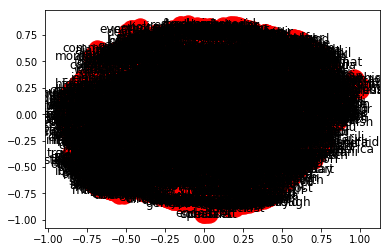

In [27]:
nx.draw_networkx(g_2mode)

With no filtering, this will not bring insight (see below). If we want even faster computation and tunable visualizations, check out [Pajek](http://mrvar.fdv.uni-lj.si/pajek/) or [gephi](https://gephi.org/).

A two-mode network can be easily transformed into two one-mode network, enabling words to be connected to other words via the number of documents that share them, or documents to be connected to other documents via the words they share:

In [28]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [29]:
gDoc = contractNetwork(g_2mode, 'doc')

Let's first take a look at the document-to-document network:

In [30]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 4950
Average degree:  99.0000


Let's construct a visualization. It is not surprising that almost every document is connected to every other. We can use edge weight to distinguish document distance (modeled as attraction):

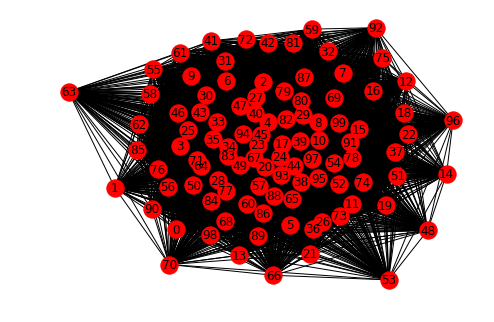

In [31]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

Lets draw the graph with high and low weight edges distinguished:

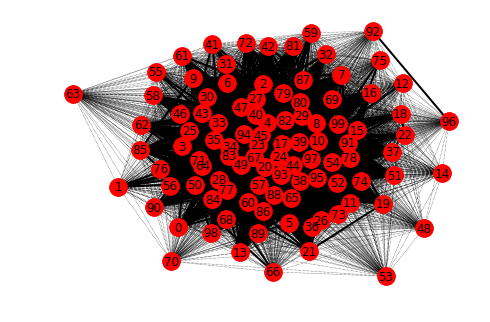

In [32]:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

Now we can see why 53 and 63 are on the outside, while 39 and 23 are at the center. We can look at them:

In [33]:
print(len(senReleasesDF.iloc[63]['text']),"words:","\n",senReleasesDF.iloc[63]['text'].strip().replace('  ', '\n'))

314 words: 
 FOR IMMEDIATE RELEASE

Senator Kennedy issued the following statement this evening following Senator Kerrys apology

John Kerry s statement says it all
I wish the Bush administration brought as much energy and focus to trying to correct their mistakes in Iraq as it did in going after John Kerry


In [34]:
print(len(senReleasesDF.iloc[23]['text']),"words:","\n",senReleasesDF.iloc[23]['text'].strip().replace('  ', '\n'))

20603 words: 
 FOR IMMEDIATE RELEASE
REID

 We re sorry that we re starting a little bit late
but the House has some votes going
and so Leader Pelosi will be here and Congresswoman Solis real soon

 I m reminded of the story I learned as a little boy
When the kid was watching the sheep and he was supposed to yell
Wolf
when the wolf was coming
And he yelled
Wolf
as we know

Wolf
Wolf
and there was never any wolf
And finally when a wolf showed up
no one came

 And no matter how hard we try to be bipartisan here in Washington
with President Bush it s the proverbial cry for wolf

 As I said leaving the chamber last night
whatever he says
it s just the opposite

 And we re here today to talk about health care
But the cry of wolf is once again ringing in my ears because he keeps talking about how he wants to improve health care and we re now five years into this and there s been no improvement

 In fact
I hope the president mentions when he s in Tennessee today that there s almost a million 

Ah...those documents with the **most** words are unsprisingly the most central in this simple document network.

Now let's turn it around and look at the word-to-word network by documents. 

In [35]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 4270
Number of edges: 2080405
Average degree: 974.4286


First, let's reduce the number of words to a manageable size.

In [36]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

1.9883402510568855

We are going to return to the sentence cooccurence graph, as it suggests many more meaningful (more local) associations. But without filtering, it is too large. Let's first drop all the edges with weight below 1250, then drop all the isolates:

In [37]:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 1250])
g.remove_nodes_from(list(nx.isolates(g))) #since we are changing the graph list() evaluates the isolates first
giant = max(nx.connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 166
Number of edges: 496
Average degree:   5.9759


A bit smaller now, Now, let's visualize it: 

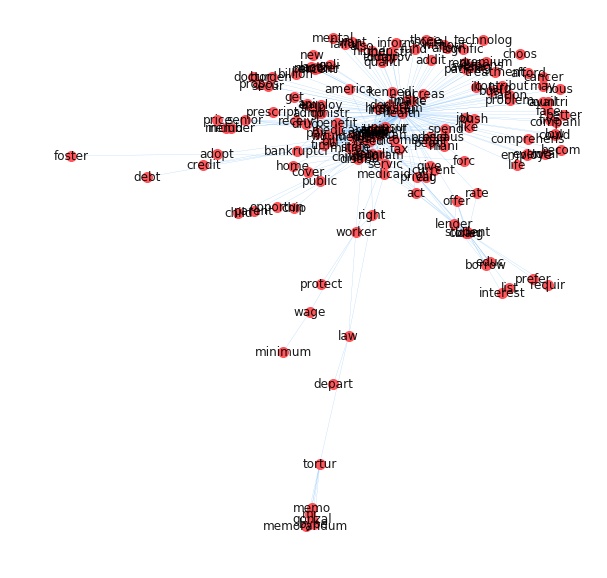

In [38]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

We can also remove those words that show up in many documents...those with many connections (note that this has a similar effect to selecting those with a high tf.idf score):

In [39]:
giant.remove_nodes_from([n for n in giant.nodes if len(set(giant.neighbors(n))) >= 2000]) 
giant.remove_nodes_from(list(nx.isolates(giant)))
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 166
Number of edges: 496
Average degree:   5.9759


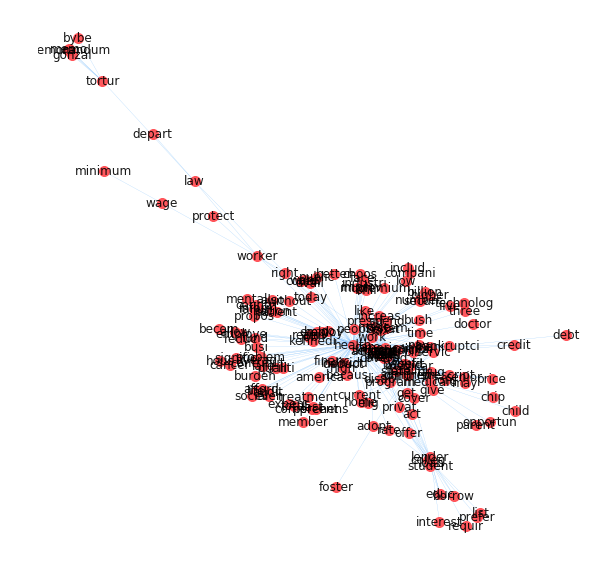

In [40]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

We can continue to trim globally to investigate the structure of words at alternative slices of network density. 

Moreover, we can find cliques, or completely connected sets of nodes. 

In [41]:
nx.clique.number_of_cliques(giant)['presid']

2

In [42]:
print(', '.join(max(nx.clique.find_cliques(giant), key = lambda x: len(x))))

health, care, cost, plan, year, insur, save, provid, american, account, uninsur


Now lets look at a subgraph of the network, those nodes that are within 1 or 2 network steps of 'america'. 

In [43]:
americanNeighbors = giant.neighbors('american')
g_american = giant.subgraph(americanNeighbors)
print(nx.info(g_american))

Name: 
Type: SubGraph
Number of nodes: 22
Number of edges: 154
Average degree:  14.0000


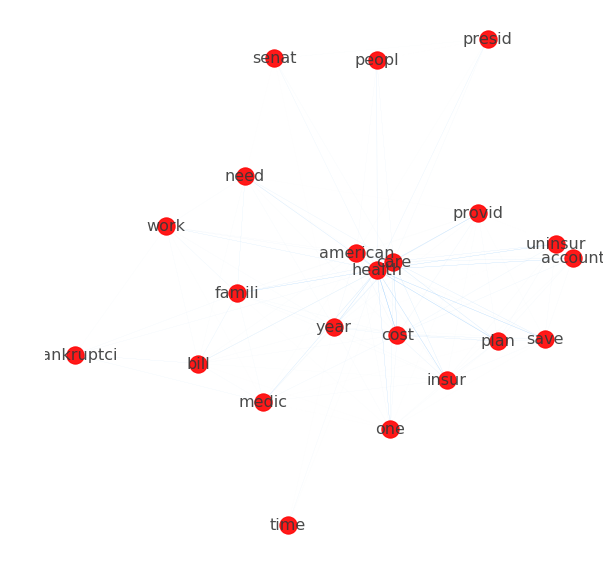

In [44]:
layout_amer = nx.spring_layout(g_american, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_american.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american.edges(data = True)))
nx.draw(g_american, ax = ax, pos = layout_amer, labels = {n:n for n in g_american.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

In [45]:
americanNeighbors = gWord.neighbors('american')
americanNeighborsPlus1 = set(americanNeighbors)
for n in americanNeighbors:
    americanNeighborsPlus1 |= set(giant.neighbors(n))
    
#for x in americanNeighborsPlus1:
#    print(x)

In [46]:
g_american2 = giant.subgraph(americanNeighborsPlus1)
print(nx.info(g_american2))

Name: 
Type: SubGraph
Number of nodes: 165
Number of edges: 474
Average degree:   5.7455


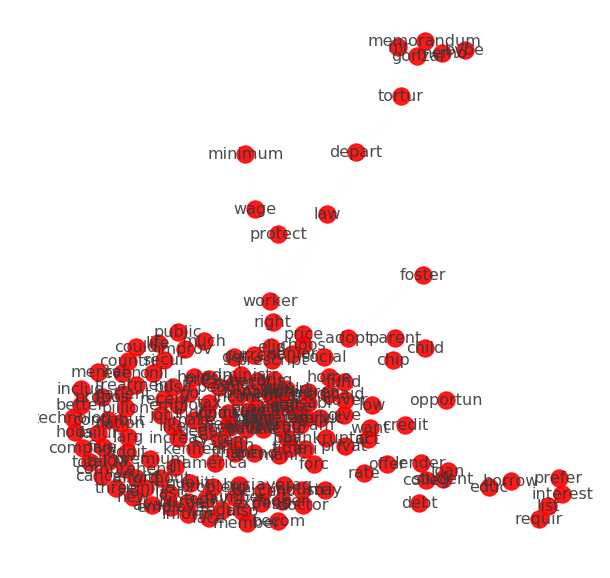

In [47]:
layout_amer = nx.spring_layout(g_american2, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_amer = nx.eigenvector_centrality(g_american2)
maxC = max(centralities_amer.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_american2.edges(data = True)))
nx.draw(g_american2, ax = ax, pos = layout_amer, labels = {n:n for n in g_american2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_american2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that render some reasonable networks to meaningfully characterize the structure of words and documents (or subdocuments like chapters or paragraphs) from your corpus. What are useful filters and thresholds and what semantic structures do they reveal that given insight into the social world and social game inscribed in your corpus? Interrogate interesting subgraphs of your network and detail what they reveal about the semantic space involved.

For this exercise, I'm using the plot summaries of sci-fi movies produced during the Great Recession. I intend to interrogate the semantic space of these plot summaries so as to investigate any clues of escapism.

In [50]:
plots = pandas.read_csv('scifi_recession.csv')
plots[:5]

movie_id           title  year  \
0   3280625       'O puorco  2009   
1   3281971        00:05'01  2008   
2   3288302  20 Years After  2008   
3   3289227            2012  2009   
4   3289786            2081  2009   

                                                plot  
0  The sacrifice of pig in some ancient ethnic gr...  
1  A scenic work about nature, human nature, and ...  
2  Everything that could go wrong did go wrong: W...  
3  Geophysicist Adrian Helmsley officially visits...  
4  A short film adaptation of Kurt Vonnegut's Har...

In [51]:
# extracting sentences, as well as tokenizing and stemming
plots['tokenized_sents'] = plots['plot'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
plots['normalized_sents'] = plots['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic) for s in x])

In [52]:
plots[:5]

movie_id           title  year  \
0   3280625       'O puorco  2009   
1   3281971        00:05'01  2008   
2   3288302  20 Years After  2008   
3   3289227            2012  2009   
4   3289786            2081  2009   

                                                plot  \
0  The sacrifice of pig in some ancient ethnic gr...   
1  A scenic work about nature, human nature, and ...   
2  Everything that could go wrong did go wrong: W...   
3  Geophysicist Adrian Helmsley officially visits...   
4  A short film adaptation of Kurt Vonnegut's Har...   

                                     tokenized_sents  \
0  [[The, sacrifice, of, pig, in, some, ancient, ...   
1  [[A, scenic, work, about, nature, ,, human, na...   
2  [[Everything, that, could, go, wrong, did, go,...   
3  [[Geophysicist, Adrian, Helmsley, officially, ...   
4  [[A, short, film, adaptation, of, Kurt, Vonneg...   

                                    normalized_sents  
0  [[sacrific, pig, ancient, ethnic, group, south...  
1  [[scenic, work, natur, human, natur, unknown, ...  
2  [[everyth, could, go, wrong, go, wrong, war, t...  
3  [[geophysicist, adrian, helmsley, offici, visi...  
4  [[short, film, adapt, kurt, vonnegut, harrison...

First, let's build a graph based on word cooccurences in the first 100 plot summaries.

In [118]:
g_plots = wordCooccurrence(plots['normalized_sents'][:100].sum())
#nx.write_graphml(g_plots, 'plots100.graphml')

In [59]:
print(nx.info(g_plots))

Name: 
Type: Graph
Number of nodes: 2143
Number of edges: 28688
Average degree:  26.7737


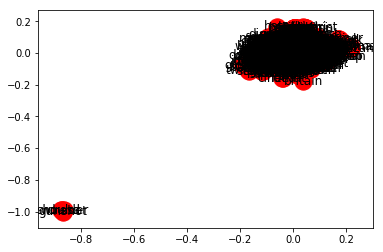

In [58]:
nx.draw_networkx(g_plots)

There are too many edges and we should do some filtering. Alternatively, we can build graphs starting with a two-mode network. Let's again use the document-word frequency matrix that we used in week 3.

In [70]:
plotsVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
plotsVects_incidence = plotsVectorizer.fit_transform(plots['plot'][:100])

In [71]:
plotsVects_incidence.shape

(100, 2143)

Let's turn the incidence matrix into a network.

In [72]:
g_2mode_plots = nx.Graph()

#define all the nodes
g_2mode_plots.add_nodes_from((plotsVectorizer.get_feature_names()[i] for i in range(plotsVects_incidence.shape[1])), bipartite = 'word')
g_2mode_plots.add_nodes_from(range(plotsVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode_plots.add_edges_from(((d, plotsVectorizer.get_feature_names()[w], {'weight' : plotsVects_incidence[d, w]}) for d, w in zip(*plotsVects_incidence.nonzero())))

In [73]:
print(nx.info(g_2mode_plots))

Name: 
Type: Graph
Number of nodes: 2243
Number of edges: 4332
Average degree:   3.8627


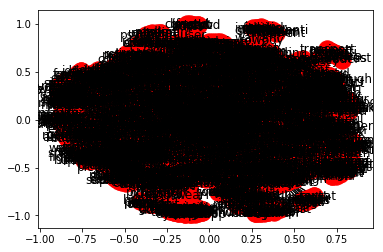

In [74]:
nx.draw_networkx(g_2mode_plots)

In [81]:
# A two-mode network can be easily transformed into two one-mode network, 
# enabling words to be connected to other words via the number of documents that share them, 
# or documents to be connected to other documents via the words they share.

## The sample confused g_2mode with g, though the results should be the same.
def contractNetwork(g_2mode, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g_2mode.neighbors(n_outside) if g_2mode.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

Let's first take a look at the document-to-document network.

In [82]:
gDoc_plots = contractNetwork(g_2mode_plots, 'doc')

In [83]:
print(nx.info(gDoc_plots))

Name: 
Type: Graph
Number of nodes: 100
Number of edges: 3626
Average degree:  72.5200


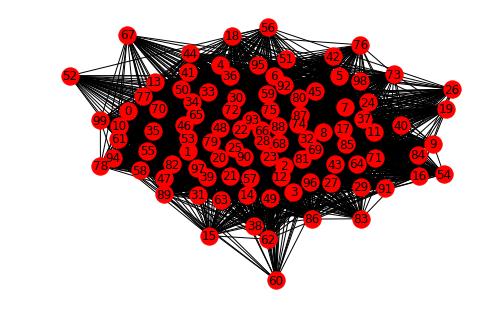

In [84]:
layout_plots1 = nx.spring_layout(gDoc_plots, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc_plots, pos = layout_plots1, labels = {n:n for n in gDoc_plots.nodes()})

It is not surprising that almost every document is connected to every other. We can use edge weight to distinguish document distance (modeled as attraction).

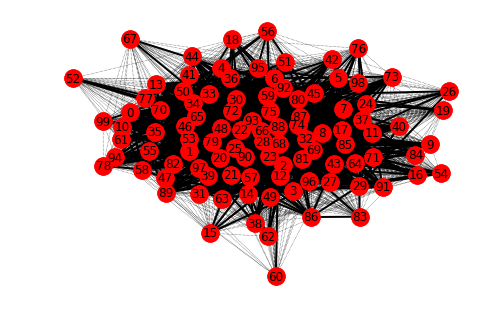

In [85]:
wMedian = np.median([d['weight'] for n1, n2, d in gDoc_plots.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc_plots.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc_plots.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc_plots, pos = layout_plots1, labels = {n:n for n in gDoc_plots.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc_plots, pos = layout_plots1, nodelist=None, edgelist = edgesHigh, width=2)

Now we can see why 52, 67, and 60 are on the outside, while 22 and 66 are at the center. We can look at them:

In [96]:
print("title:", plots.iloc[52]['title'],"\n",len(plots.iloc[52]['plot']),"words:","\n",plots.iloc[52]['plot'].strip().replace('  ', '\n'))

title: Canary 
 268 words: 
 Canary Industries specializes in "organ redistribution" or leasing organs to people who need them. The catch is that those who accept these organs must also sign a "Conscientious Usage" contract that allows Canary to repo the organs if the recipient abuses their body.


In [97]:
print("title:", plots.iloc[67]['title'],"\n",len(plots.iloc[67]['plot']),"words:","\n",plots.iloc[67]['plot'].strip().replace('  ', '\n'))

title: Civilian 
 282 words: 
 Circa 1964, the psychiatrist, Dr. Benjamin Simon, puts his patient, Betty Hill, under hypnosis. In the dream state, she tells him of being in a medical ward and speaking to "the leader". The leader shows her an animate map of stars. The experience is both beautiful and frightening.


In [98]:
print("title:", plots.iloc[60]['title'],"\n",len(plots.iloc[60]['plot']),"words:","\n",plots.iloc[60]['plot'].strip().replace('  ', '\n'))

title: Chompers 
 241 words: 
 In the spirit of the Twlight Zone, an old toothless, beggar woman is on the brink of starvation when her shaggy mutt uncovers a pair of pristine dentures in the streets. Suddenly, she can eat whatever she likes, but her hunger is insatiable.


In [99]:
print("title:", plots.iloc[22]['title'],"\n",len(plots.iloc[22]['plot']),"words:","\n",plots.iloc[22]['plot'].strip().replace('  ', '\n'))

title: Alien Trespass 
 1457 words: 
 The story begins in 1957 in the star-filled skies above California's Mojave Desert. It is a special night for noted astronomer Ted Lewis, who is preparing a special dinner for his beautiful, adoring wife Lana to celebrate their wedding anniversary. In another part of town, Tammy, a waitress at small local diner with big plans for the future, looks out her window and is excited to see a shooting star, which she takes as a good sign for her dreams. But, what Dr. Lewis and Tammy assume is a shooting star, is really an alien spaceship. The fiery ball hurtles toward earth and crash-lands on a butte in the desert. The only witnesses are teens Dick and Penny who are necking in a nearby lover's lane. A tall, metallic alien named Urp emerges from the craft unharmed, alarmed to discover that the monstrous Ghota, who was also on board, has escaped. The menacing one-eyed creature's unquenchable appetite could mean the end of civilization as we know it. Urp is 

In [100]:
print("title:", plots.iloc[66]['title'],"\n",len(plots.iloc[66]['plot']),"words:","\n",plots.iloc[66]['plot'].strip().replace('  ', '\n'))

title: City of Ember 
 1197 words: 
 At the end of mankind on Earth, scientists build a self-sufficient underground city for a few people in order to preserve the human race for two hundred years. They leave also instructions for the future generations to return to the surface of the planet in a steel box that should be kept by the mayors through the generations. However, the instructions are lost and the inhabitants stay in the city that is completely deteriorated. The power generator has problems and the blackouts are longer and more frequent and the city is running out of food that needs to be rationed. On the Assignment Day, the teenagers Lina Mayfleet and Doon Harrow are assigned to work with the pipework and as messenger, but they swap their job positions. Lina, who is the descendant of the seventh mayor, finds the box of instructions in the house of her grandmother and shows it to her friend Doon. They decide to explore the way out of the city and they discover that the corrupt 

It seems that we get the same results as from Senator Release sample above. Those documents with the most words are unsprisingly the most central in this simple document network and those shortest are on the outside.

Now let's turn it around and look at the word-to-word network by documents.

In [102]:
gWord_plots = contractNetwork(g_2mode_plots, 'word')
print(nx.info(gWord_plots))

Name: 
Type: Graph
Number of nodes: 2143
Number of edges: 108919
Average degree: 101.6510


First, let's reduce the number of words to a manageable size.

In [103]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord_plots.edges(data = True)])
wMean

1.066251067306898

We are going to return to the sentence cooccurence graph, as it suggests many more meaningful (more local) associations. But without filtering, it is too large. Let's first drop all the edges with weight below 2, then drop all the isolates.

In [119]:
g_plots.remove_edges_from([(n1, n2) for n1, n2, d in g_plots.edges(data = True) if d['weight'] <= 2])
g_plots.remove_nodes_from(list(nx.isolates(g_plots))) #since we are changing the graph list() evaluates the isolates first
giant_plots = max(nx.connected_component_subgraphs(g_plots), key=len) # keep just the giant connected component
print(nx.info(giant_plots))

Name: 
Type: Graph
Number of nodes: 199
Number of edges: 298
Average degree:   2.9950


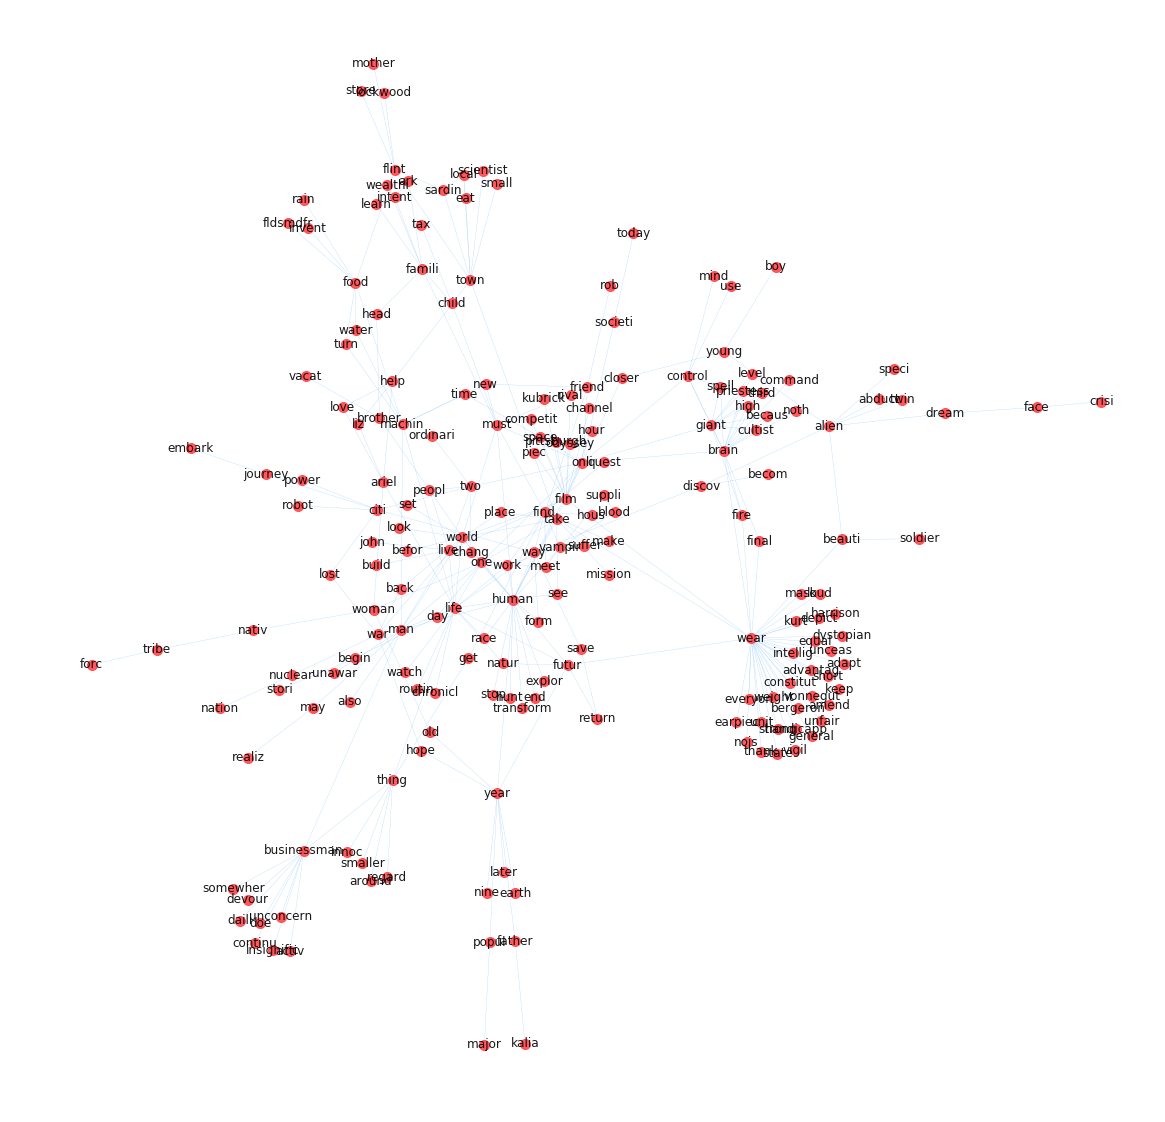

In [120]:
layout_plots2 = nx.spring_layout(giant_plots, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (20,20))
nx.draw(giant_plots, ax = ax, pos = layout_plots2, labels = {n:n for n in giant_plots.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue')

We can observe that "place", "human", "world", "space", "live", "place", "vampire" are at the very center of the plot. And there are "scientist", "robot", "alien", etc. present in this plot. This provides the general idea of sci-fi films. People could probably guess the genre of films in this dataset I'm using based on this plot.

we can find cliques, or completely connected sets of nodes.

In [121]:
print(', '.join(max(nx.clique.find_cliques(giant_plots), key = lambda x: len(x))))

world, human, one, life, man


The semantic network of sci-fi movies does indicate escapism in terms of depicting "alien", "robot", "space", "machine", "time", etc., and main topic of these movies are world, human, life, man, which implies that these movies are about broader topics than individual and family. People are looking at the fate of human beings rather than individuals, which echos with the common depressed situation people are in. Let's take a look at some sub-graphs carefully.

In [122]:
worldNeighbors = giant_plots.neighbors('world')
g_world = giant_plots.subgraph(worldNeighbors)
print(nx.info(g_world))

Name: 
Type: SubGraph
Number of nodes: 14
Number of edges: 16
Average degree:   2.2857


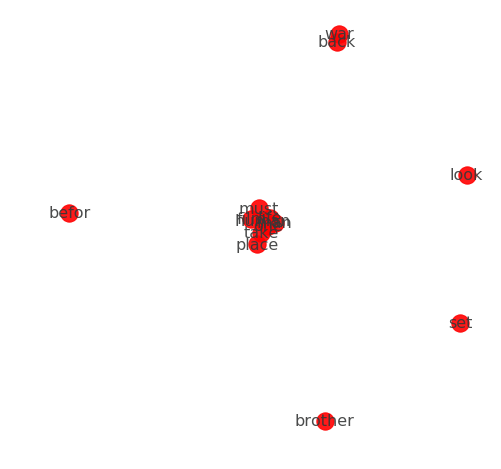

In [130]:
layout_world = nx.spring_layout(g_world, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (8,8))
maxWeight = max((d['weight'] for n1, n2, d in g_world.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_world.edges(data = True)))
nx.draw(g_world, ax = ax, pos = layout_world, labels = {n:n for n in g_world.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_world.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))

In [132]:
worldNeighbors1 = gWord_plots.neighbors('world')
worldNeighborsPlus1 = set(worldNeighbors1)
for n in worldNeighbors1:
    worldNeighborsPlus1 |= set(giant_plots.neighbors(n))

In [133]:
g_world1 = giant_plots.subgraph(worldNeighborsPlus1)
print(nx.info(g_world1))

Name: 
Type: SubGraph
Number of nodes: 129
Number of edges: 180
Average degree:   2.7907


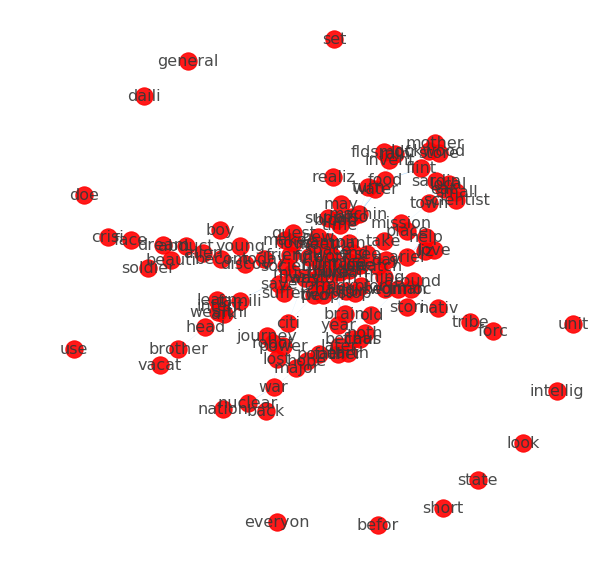

In [134]:
layout_world1 = nx.spring_layout(g_world1, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
centralities_world = nx.eigenvector_centrality(g_world1)
maxC = max(centralities_world.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_world1.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_world1.edges(data = True)))
nx.draw(g_world1, ax = ax, pos = layout_world1, labels = {n:n for n in g_world1.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_world1.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))

# Network Statistics
We can often gain more insight into our semantic network through statistics that describe the positions of words within it.

We begin with measures of centrality. The concept of centrality is that some nodes (words or documents) are more *central* to the network than others. The most straightforward is the notion of degree centrality: those nodes that have the highest number of connections are the most central. Here our measure normalizes the number of connections by those with the most connections.

In [135]:
dcentralities = nx.degree_centrality(giant)

In [136]:
dcentralities['senat']

0.048484848484848485

In [137]:
max(dcentralities.items(), key = lambda x : x[1])

('health', 0.8242424242424242)

We can color and size the nodes by betweenness centrality, it's much faster to redraw since we aren't redoing the layout.

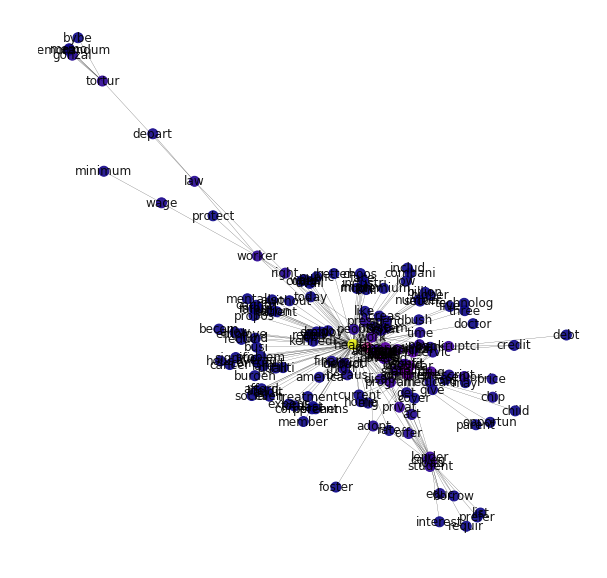

In [138]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Another way to visualize the graph involes the use of size to represent degree centrality and edge weight:

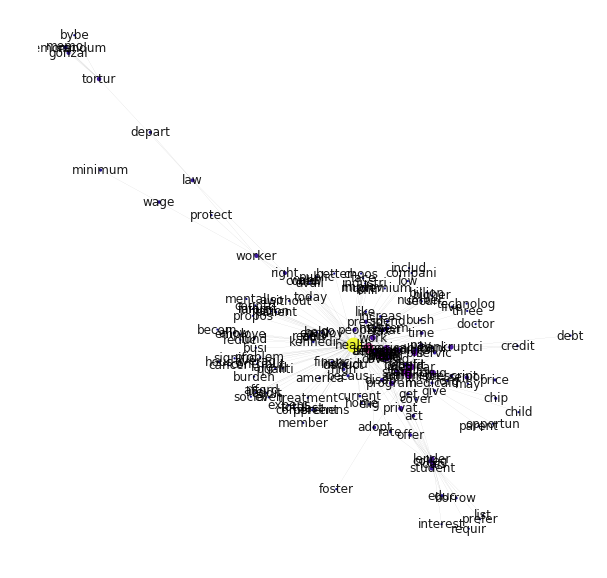

In [139]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

The distrubution of degree centrality is:

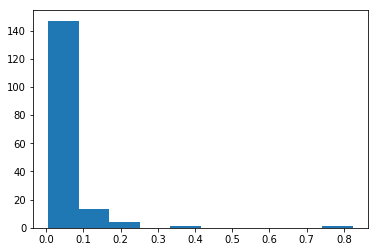

In [140]:
plt.hist(list(dcentralities.values()))
plt.show()

What are the top and bottom ten words in terms of degree?

In [141]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.8242424242424242),
 ('care', 0.36363636363636365),
 ('cost', 0.23636363636363636),
 ('famili', 0.19393939393939394),
 ('children', 0.17575757575757575),
 ('year', 0.1696969696969697),
 ('plan', 0.15757575757575756),
 ('medicar', 0.1393939393939394),
 ('american', 0.1393939393939394),
 ('bill', 0.13333333333333333)]

In [142]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('total', 0.006060606060606061),
 ('fund', 0.006060606060606061),
 ('bybe', 0.006060606060606061),
 ('signific', 0.006060606060606061),
 ('public', 0.006060606060606061),
 ('larg', 0.006060606060606061),
 ('social', 0.006060606060606061),
 ('prefer', 0.006060606060606061),
 ('premium', 0.006060606060606061),
 ('industri', 0.006060606060606061)]

Consider another very different measure, which is *betweenness* centrality. Betweenness centrality distinguishes nodes that require the most shortest pathways between all other nodes in the network. Semantically, words with a high betweenness centrality may link distinctive domains, rather than being "central" to any one. In other words, high *betweenness centrality* nodes may not have the highest *degree centrality*.

In [143]:
centralities = nx.betweenness.betweenness_centrality(giant)

In [144]:
centralities['senat']

3.695491500369549e-05

In [145]:
max(centralities.items(), key = lambda x : x[1])

('health', 0.7974546258832458)

We can color and size the nodes by betweenness centrality:

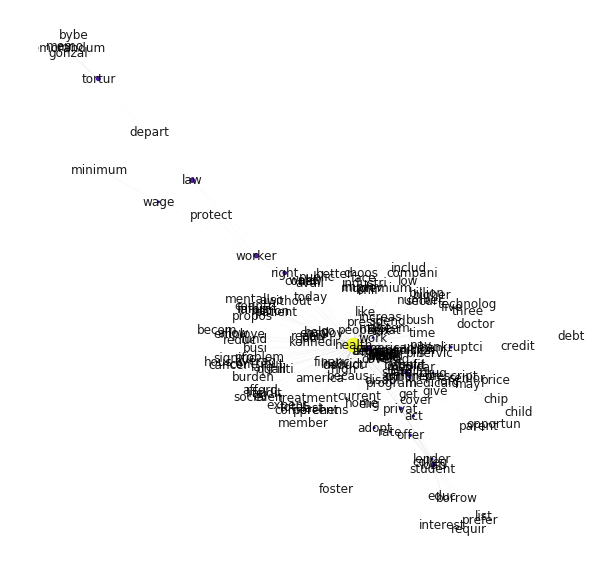

In [146]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

The distrubution of betweenness centrality is:

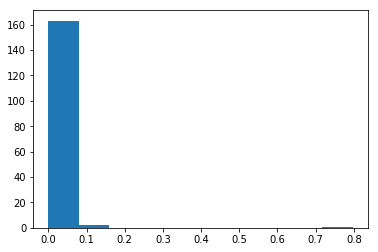

In [147]:
plt.hist(list(centralities.values()))
plt.show()

This is an exponential distrubution, but you might need to add more nodes to see it clearly.

What are the top ten words in terms of betweenness?

In [148]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.8242424242424242),
 ('care', 0.36363636363636365),
 ('cost', 0.23636363636363636),
 ('famili', 0.19393939393939394),
 ('children', 0.17575757575757575),
 ('year', 0.1696969696969697),
 ('plan', 0.15757575757575756),
 ('medicar', 0.1393939393939394),
 ('american', 0.1393939393939394),
 ('bill', 0.13333333333333333)]

Here it appears that "health"/"care"/"cost"/"medicar", "famili"/"children", and "bill" are key concepts that connect others in the broader network. This is interesting in that they seem to be domain-specific rather than linking words like "service" and "system".

What are words lower down?

In [149]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[50:60]

[('wage', 0.024242424242424242),
 ('prescript', 0.024242424242424242),
 ('deduct', 0.024242424242424242),
 ('mr', 0.024242424242424242),
 ('system', 0.024242424242424242),
 ('tax', 0.024242424242424242),
 ('servic', 0.024242424242424242),
 ('individu', 0.024242424242424242),
 ('make', 0.01818181818181818),
 ('give', 0.01818181818181818)]

We can also look at closeness centrality, or the average Euclidean or path distance between a node and all others in the network. A node with the highest closeness centrality is most likely to send a signal with the most coverage to the rest of the network.

In [150]:
centralities = nx.closeness_centrality(giant)

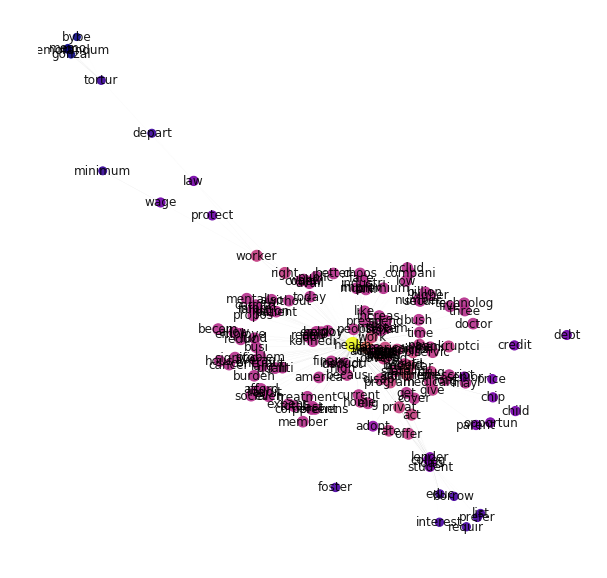

In [151]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Top and bottom:

In [152]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.7638888888888888),
 ('care', 0.559322033898305),
 ('cost', 0.5092592592592593),
 ('famili', 0.5045871559633027),
 ('year', 0.4881656804733728),
 ('children', 0.4881656804733728),
 ('work', 0.4824561403508772),
 ('plan', 0.48104956268221577),
 ('bill', 0.4796511627906977),
 ('medicar', 0.4782608695652174)]

In [153]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('requir', 0.26357827476038337),
 ('prefer', 0.26357827476038337),
 ('tortur', 0.25152439024390244),
 ('depart', 0.24774774774774774),
 ('minimum', 0.24193548387096775),
 ('gonzal', 0.20195838433292534),
 ('memorandum', 0.20146520146520147),
 ('mr', 0.20146520146520147),
 ('memo', 0.20146520146520147),
 ('bybe', 0.20121951219512196)]

Or eignvector centrality, an approach that weights degree by the centrality of those to whom one is tied (and the degree to whom they are tied, etc.) In short, its an $n$th order degree measure.

In [154]:
centralities = nx.eigenvector_centrality(giant)

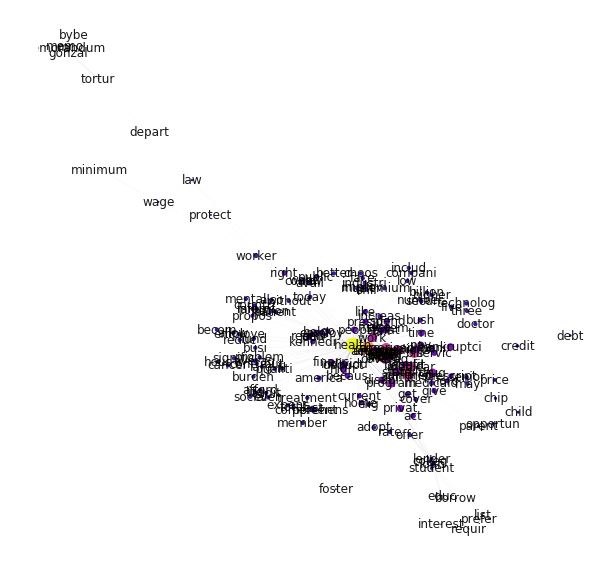

In [155]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Note how the colors reveal a much more graduate distribution here. Let's look at it directly.

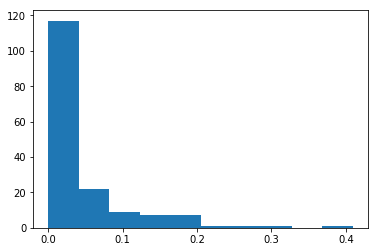

In [156]:
plt.hist(list(centralities.values()))
plt.show()

Top and bottom:

In [157]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('health', 0.40940548651463926),
 ('care', 0.3141036090564929),
 ('cost', 0.26371184725651653),
 ('year', 0.22637895749862894),
 ('famili', 0.20307993427970292),
 ('plan', 0.1910815042884893),
 ('american', 0.1879454382922956),
 ('bill', 0.17714627787143075),
 ('insur', 0.17568249050178794),
 ('medicar', 0.16513397986452089)]

In [158]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('requir', 0.0011729540088679324),
 ('prefer', 0.0011729540088679324),
 ('tortur', 0.00022811912384458765),
 ('depart', 0.0002245485671385195),
 ('minimum', 9.793307562753276e-05),
 ('gonzal', 1.4632892023819244e-05),
 ('mr', 1.3319282015842154e-05),
 ('memorandum', 1.2626439035859916e-05),
 ('memo', 1.2626439035859916e-05),
 ('bybe', 1.1865270167541114e-05)]

We can now filter our network by a centrality measure. Let's define a function and experiment with it:

In [159]:
def filterWords(G, minWeight = 3, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

In [160]:
giant_filtered30 = filterWords(giant, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(giant_filtered30))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 111
Average degree:   8.8800


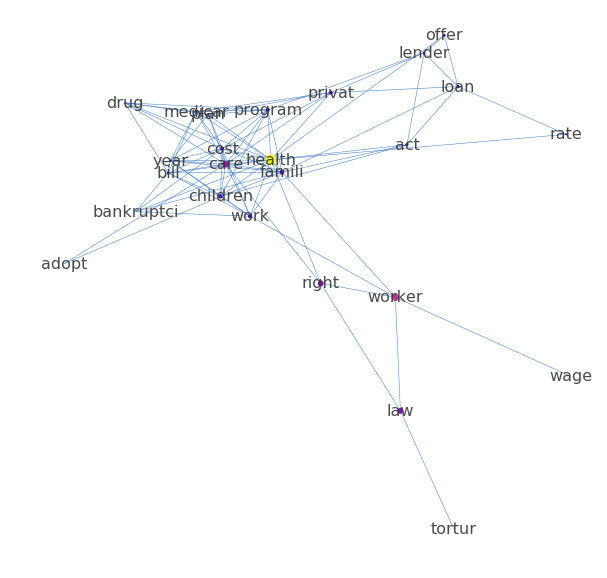

In [161]:
layout_giant_filtered30 = nx.spring_layout(giant_filtered30, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant30 = nx.betweenness_centrality(giant_filtered30)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered30.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered30.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

We can also look at global statistics, like the density of a network, defined as the number of actual edges divided by the total number of possible edges:

In [162]:
nx.density(giant)

0.0362175976633808

We can also calculate the average degree per node:

In [163]:
np.mean([v for w,v in nx.degree(giant)])

5.975903614457831

The diameter calculates the average distance between any two nodes in the network:

In [164]:
nx.diameter(giant)

7

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that calculate different kinds of centrality for distinct words or documents in a network composed from your corpus of interest. Which type of words tend to be most and least central? Can you identify how different centrality measures distinguish different kind of words in your corpus? What do these patterns suggest about the semantic content and structure of your documents? Finally, calculate global measure for your network(s) and discuss what they reveal.

In [165]:
dcentralities_plots = nx.degree_centrality(giant_plots)

In [167]:
dcentralities_plots['world']

0.07070707070707072

In [168]:
dcentralities_plots['human']

0.11111111111111112

In [173]:
dcentralities_plots['life']

0.09595959595959597

Seems that these words are not that central, which is different from my expectation.

In [170]:
max(dcentralities_plots.items(), key = lambda x : x[1])

('wear', 0.19191919191919193)

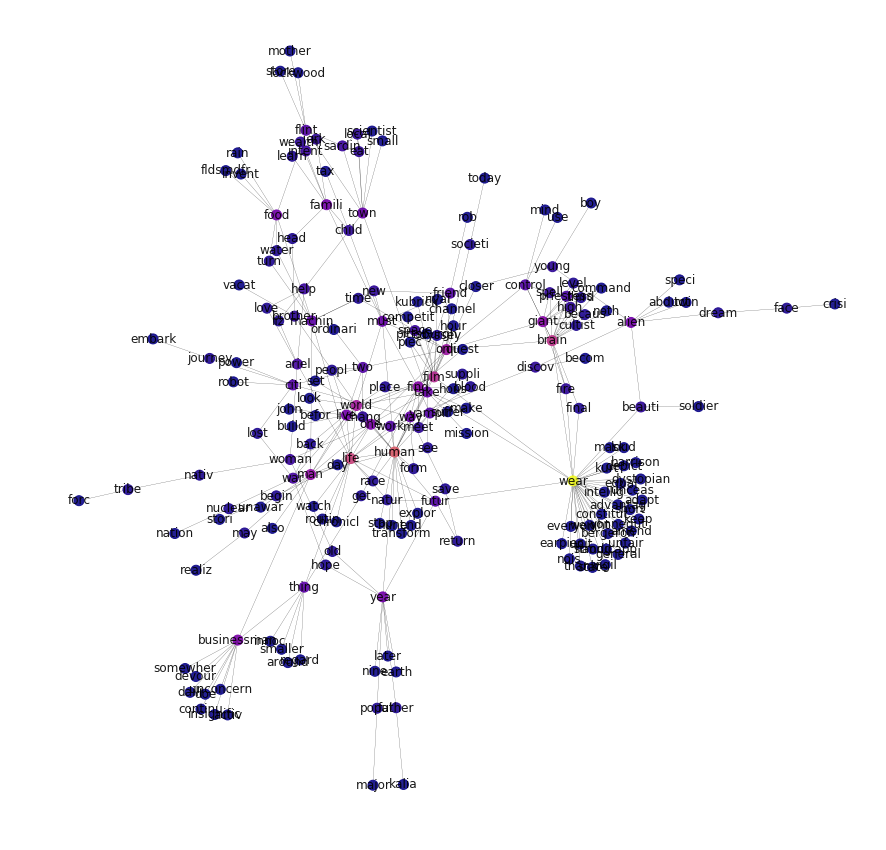

In [172]:
fig, ax = plt.subplots(figsize = (15,15))
maxC = max(dcentralities_plots.items(), key = lambda x : x[1])[1]
nx.draw(giant_plots, ax = ax, pos = layout_plots2, labels = {n:n for n in giant_plots.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities_plots[n] / maxC for n in giant_plots.nodes],
        cmap = plt.get_cmap('plasma'))

It turns out that "human", "life", "world" are already quite central but since the overall network is relatively scattered, the degree centrality is not high. Besides these words, we can see that "man", "brain", "giant", "alien", "year", "businessman" is quite central, which illustrated the characterstics of sci-fi movies and serves as a supporting evidence that sci-fi moviews are great sources for people to escape from the daily life. However, it is interesting to observe that "businessman" is also quite central, and it would be more facinating to analyze how they are depicted in the films in this period.

In [178]:
busiNeighbors = giant_plots.neighbors('businessman')
g_busi = giant_plots.subgraph(busiNeighbors)
print(nx.info(g_busi))

Name: 
Type: SubGraph
Number of nodes: 10
Number of edges: 1
Average degree:   0.2000


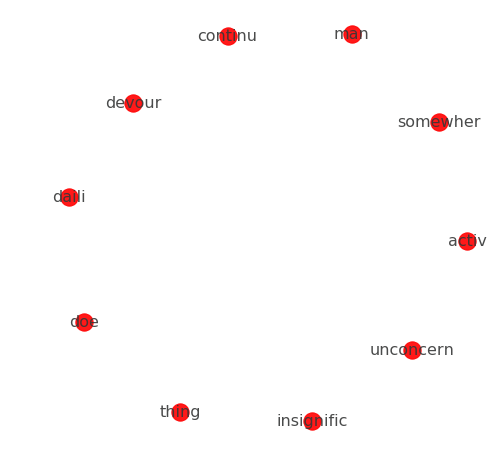

In [179]:
layout_busi = nx.spring_layout(g_busi, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (8,8))
maxWeight = max((d['weight'] for n1, n2, d in g_busi.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_busi.edges(data = True)))
nx.draw(g_busi, ax = ax, pos = layout_busi, labels = {n:n for n in g_busi.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_busi.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma'))

These are words surrounding "businessman". Though the data is small and filtered, we can still see that businessman "devour", "unconcern", "insignific", which indicates a somehow negative image, who are poor, diffident, and unimportant. This might implies that businessmen are not that pleasant for people during the recession.

Let's visualize the graph with the use of size to represent degree centrality and edge weight.

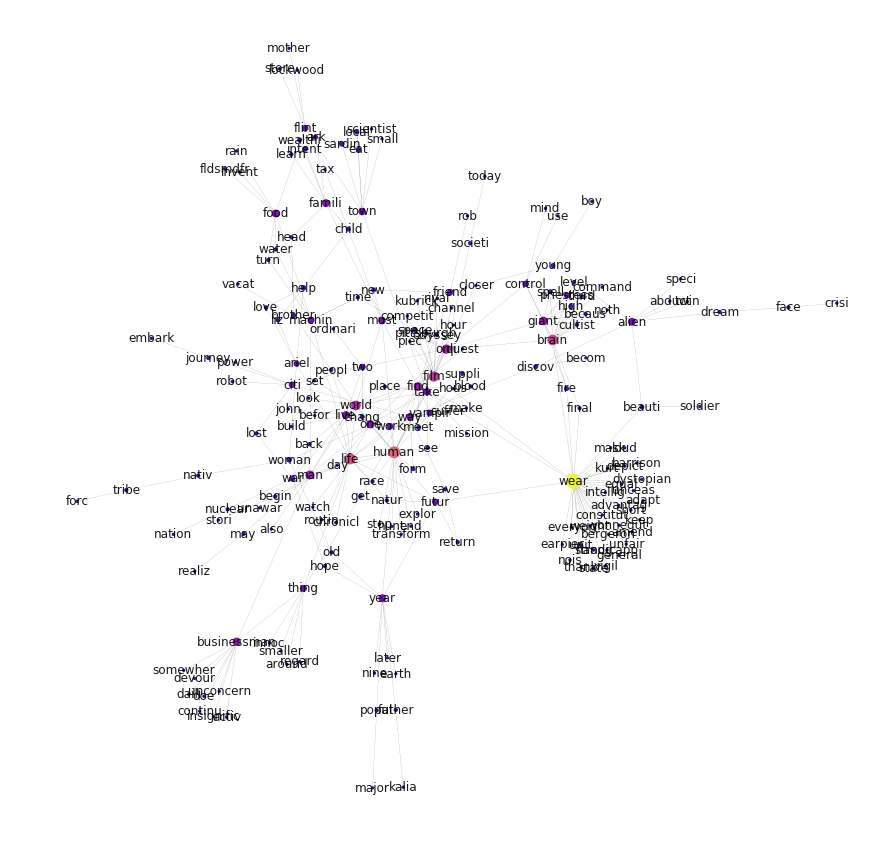

In [174]:
fig, ax = plt.subplots(figsize = (15,15))
maxC = max(dcentralities_plots.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant_plots.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant_plots.edges(data = True)))
nx.draw(giant_plots, ax = ax, pos = layout_plots2, labels = {n:n for n in giant_plots.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord_plots.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities_plots[n] / maxC for n in giant_plots.nodes],
        node_size = [dcentralities_plots[n] / maxC * 200 for n in giant_plots.nodes],
        cmap = plt.get_cmap('plasma'))

The distrubution of degree centrality is:

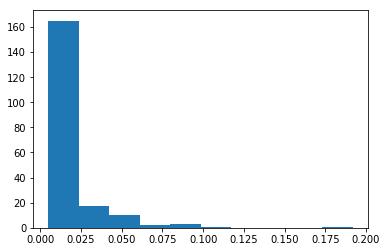

In [175]:
plt.hist(list(dcentralities_plots.values()))
plt.show()

Top and bottom ten words in terms of degree:

In [176]:
sorted(dcentralities_plots.items(), key = lambda x: x[1], reverse = True)[:10]

[('wear', 0.19191919191919193),
 ('human', 0.11111111111111112),
 ('life', 0.09595959595959597),
 ('brain', 0.08585858585858587),
 ('film', 0.08080808080808081),
 ('world', 0.07070707070707072),
 ('onli', 0.06565656565656566),
 ('man', 0.06060606060606061),
 ('giant', 0.05555555555555556),
 ('find', 0.05555555555555556)]

In [177]:
sorted(dcentralities_plots.items(), key = lambda x: x[1], reverse = True)[-10:]

[('amend', 0.005050505050505051),
 ('build', 0.005050505050505051),
 ('rob', 0.005050505050505051),
 ('today', 0.005050505050505051),
 ('innoc', 0.005050505050505051),
 ('around', 0.005050505050505051),
 ('keep', 0.005050505050505051),
 ('stori', 0.005050505050505051),
 ('twin', 0.005050505050505051),
 ('small', 0.005050505050505051)]

Then let's look at the betweenness centrality.

In [185]:
bcentralities_plots = nx.betweenness.betweenness_centrality(giant_plots)

In [186]:
max(bcentralities_plots.items(), key = lambda x : x[1])

('wear', 0.3366207105341966)

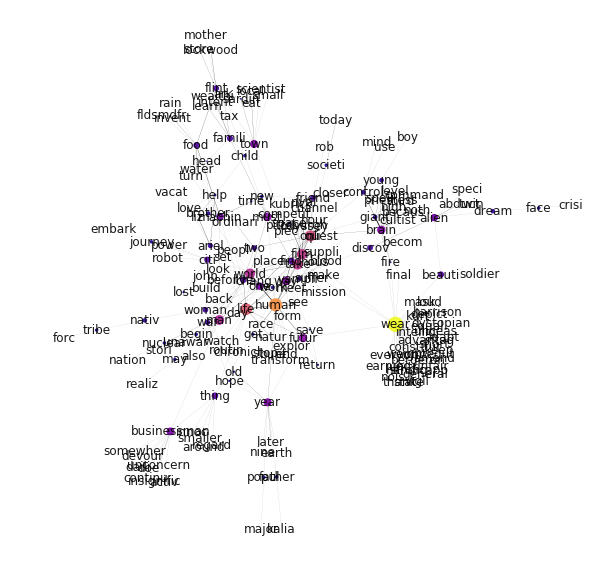

In [187]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(bcentralities_plots.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant_plots.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant_plots.edges(data = True)))
nx.draw(giant_plots, ax = ax, pos = layout_plots2, labels = {n:n for n in giant_plots.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant_plots.edges(data = True)], 
        alpha = .9, 
        node_color = [bcentralities_plots[n] / maxC for n in giant_plots.nodes],
        node_size = [bcentralities_plots[n] / maxC * 200 for n in giant_plots.nodes],
        cmap = plt.get_cmap('plasma'))

The distrubution of betweenness centrality is:

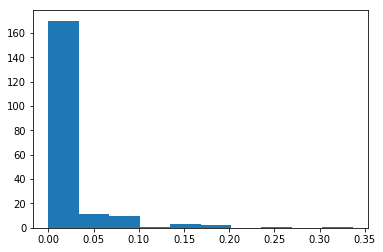

In [188]:
plt.hist(list(bcentralities_plots.values()))
plt.show()

Top and bottom ten words in terms of betweenness:

In [190]:
sorted(bcentralities_plots.items(), key = lambda x: x[1], reverse = True)[:10]

[('wear', 0.3366207105341966),
 ('human', 0.24938224285691388),
 ('life', 0.18722047454754726),
 ('onli', 0.16940861822172626),
 ('film', 0.1476927460384756),
 ('take', 0.14682090647494953),
 ('world', 0.13624764485333457),
 ('man', 0.12724319616847665),
 ('futur', 0.095753867032366),
 ('way', 0.09424367613107798)]

In [201]:
sorted(bcentralities_plots.items(), key = lambda x: x[1], reverse = True)[55:65]

[('time', 0.0025176975560862987),
 ('old', 0.002508161137602762),
 ('chang', 0.002488659894760314),
 ('hope', 0.0021808610641097952),
 ('return', 0.002145457475406714),
 ('fire', 0.0011520205682642233),
 ('save', 0.001062229742432788),
 ('sardin', 0.0006409270368661232),
 ('head', 0.0006152899553914783),
 ('intent', 5.1274162949289855e-05)]

The results of betweenness centrality is similar to degree centrality. "future" appears in the top ten words, but it also obtains high degree centrality.

Let's look at the closeness centrality.

In [203]:
ccentralities_plots = nx.closeness_centrality(giant_plots)

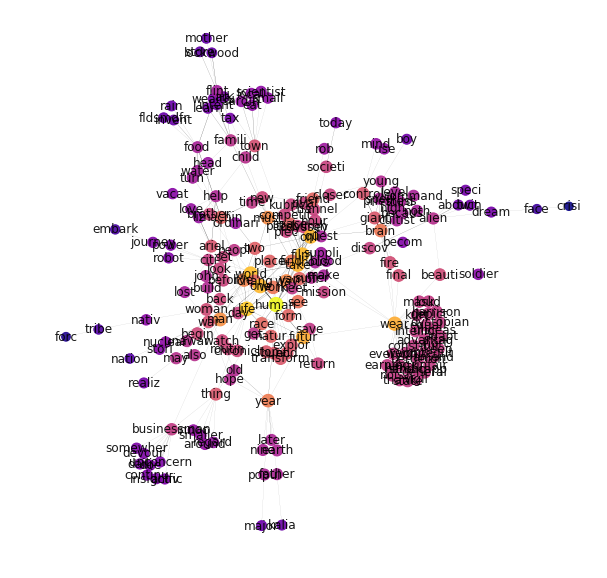

In [204]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(ccentralities_plots.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant_plots.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant_plots.edges(data = True)))
nx.draw(giant_plots, ax = ax, pos = layout_plots2, labels = {n:n for n in giant_plots.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant_plots.edges(data = True)], 
        alpha = .9, 
        node_color = [ccentralities_plots[n] / maxC for n in giant_plots.nodes],
        node_size = [ccentralities_plots[n] / maxC * 200 for n in giant_plots.nodes],
        cmap = plt.get_cmap('plasma'))

Top and bottom ten words in terms of closeness:

In [205]:
sorted(ccentralities_plots.items(), key = lambda x: x[1], reverse = True)[:10]

[('human', 0.38671875),
 ('life', 0.35804701627486435),
 ('world', 0.35231316725978645),
 ('film', 0.35106382978723405),
 ('one', 0.3492063492063492),
 ('onli', 0.34797891036906853),
 ('take', 0.34554973821989526),
 ('futur', 0.3407917383820998),
 ('wear', 0.3407917383820998),
 ('man', 0.32142857142857145)]

In [206]:
sorted(ccentralities_plots.items(), key = lambda x: x[1], reverse = True)[-10:]

[('rain', 0.18875119161105816),
 ('lockwood', 0.18626528692380057),
 ('store', 0.18626528692380057),
 ('mother', 0.18626528692380057),
 ('nation', 0.17662801070472792),
 ('tribe', 0.1756876663708962),
 ('embark', 0.16981132075471697),
 ('face', 0.16486261448792672),
 ('forc', 0.14954682779456194),
 ('crisi', 0.14163090128755365)]

This seems more informative. "human", "life", "world" are most likely to send a signal with the most coverage to the rest of the network, which means that they are the core of the sci-fi movies.

Let's look at the eignvector centrality.

In [208]:
ecentralities_plots = nx.eigenvector_centrality(giant_plots)

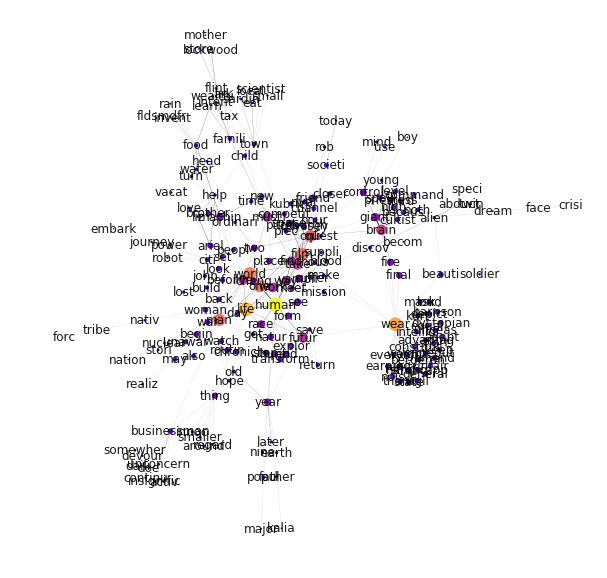

In [209]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(ecentralities_plots.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant_plots.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant_plots.edges(data = True)))
nx.draw(giant_plots, ax = ax, pos = layout_plots2, labels = {n:n for n in giant_plots.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant_plots.edges(data = True)], 
        alpha = .9, 
        node_color = [ecentralities_plots[n] / maxC for n in giant_plots.nodes],
        node_size = [ecentralities_plots[n] / maxC * 200 for n in giant_plots.nodes],
        cmap = plt.get_cmap('plasma'))

Top and bottom ten words in terms of eigenvector:

In [210]:
sorted(ecentralities_plots.items(), key = lambda x: x[1], reverse = True)[:10]

[('human', 0.380834038473614),
 ('life', 0.32073064123995165),
 ('wear', 0.2946042711791356),
 ('world', 0.2576516405574246),
 ('one', 0.24434272214465028),
 ('film', 0.2391312530757501),
 ('man', 0.23070183252253007),
 ('onli', 0.22189503920553683),
 ('take', 0.17397609407428138),
 ('brain', 0.1673326684397301)]

In [211]:
sorted(ecentralities_plots.items(), key = lambda x: x[1], reverse = True)[-10:]

[('kalia', 0.0013169564338872007),
 ('lockwood', 0.000898893622651696),
 ('store', 0.000898893622651696),
 ('mother', 0.000898893622651696),
 ('nation', 0.0007024878767055587),
 ('tribe', 0.000690437181328927),
 ('embark', 0.00044772189739282996),
 ('face', 0.00018509342980707104),
 ('forc', 8.869770897535238e-05),
 ('crisi', 2.378004058844435e-05)]

This also provide some similar results. All these centrality measurement provide information about the main topic of sci-fi films and distinguish them from some words describing specific actions or things, if we take a look at the bottom words.

We can now filter our network by a centrality measure.

In [212]:
giant_plots_filtered30 = filterWords(giant_plots, minWeight=1, filter_='closeness', rule='number', value_of_rule=30)
print(nx.info(giant_plots_filtered30))

Total number of nodes(after filtering) in the graph is 30
Name: 
Type: Graph
Number of nodes: 30
Number of edges: 75
Average degree:   5.0000


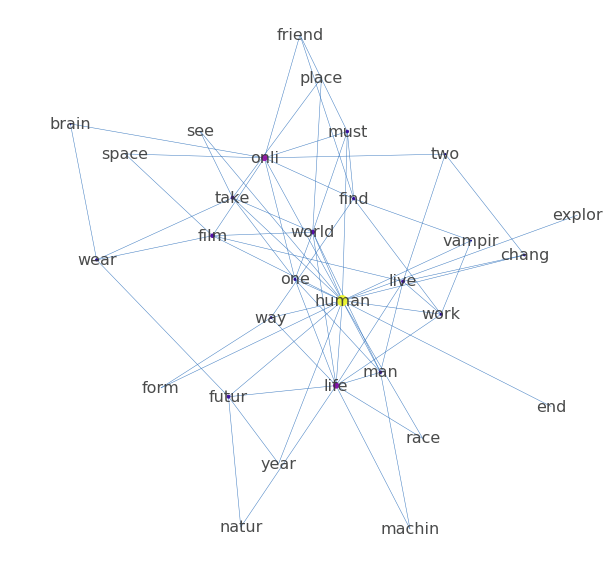

In [213]:
layout_giant_plots_filtered30 = nx.spring_layout(giant_plots_filtered30, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_plots_giant30 = nx.betweenness_centrality(giant_plots_filtered30)
maxC = max(centralities_plots_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_plots_filtered30, ax = ax, pos = layout_giant_plots_filtered30, labels = {n: n for n in giant_plots_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_plots_giant30[n] / maxC for n in giant_plots_filtered30.nodes],
        node_size = [centralities_plots_giant30[n] / maxC * 100 for n in giant_plots_filtered30.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

In the semantic world showed in the network plot above, human is the center of the world, and human is trying to live, find, work, with man, vampire, race, machine, friend, now or in the future. It is pretty interesting that this plot has captured the basic features of sci-fi films.

We can also look at global statistics, like the density of a network, defined as the number of actual edges divided by the total number of possible edges.

In [214]:
nx.density(giant_plots)

0.015126135729150805

We can also calculate the average degree per node.

In [215]:
np.mean([v for w,v in nx.degree(giant_plots)])

2.9949748743718594

We can also calculate the average distance between any two nodes in the network.

In [216]:
nx.diameter(giant_plots)

11

The global statistics have revealed that the network of sci-fi movie plots are quite scattered, which may result from two reasons that I can think of. One is that the data size is small so that the distribution is scattered and some words have been filtered because of low weight of edges. Another reason might be that the plot summaries are from different users with different writing style, making it less possible to describe the same scenario with same wording and also making it less easier to understand the movies simply based on plots.

# POS based networks

Now let's look at links between specific parts of speech within a network.

For this we will be using the `nltk` POS facilities instead of the Stanford ones. These are much faster, but also somewhat less accurate. (You get what you *pay* for in computational power).

Let's look at nouns co-occurring in sentences using the top 10 (by score) reddit posts on thread topics we have explored in prior sessions:

In [217]:
redditDF = pandas.read_csv('../data/reddit.csv', index_col = 0)

In [218]:
redditTopScores = redditDF.sort_values('score')[-100:]
redditTopScores['sentences'] = redditTopScores['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
redditTopScores.index = range(len(redditTopScores) - 1, -1,-1) #Reindex to make things nice in the future
redditTopScores[:3]

author  over_18  score                subreddit  \
99  jimmy_three_shoes    False   4990  Tales From Tech Support   
98         badbfriend    False   5034            Relationships   
97             Fafrdr    False   5146            Relationships   

                                                 text  \
99  This happened a little while ago, when I was c...   
98  https://www.reddit.com/r/relationships/comment...   
97  First post: https://www.reddit.com/r/relations...   

                                                title  \
99   We've tried nothing, and we're all out of ideas!   
98  Me [29 M] with my g/f [27 F] together 4 years,...   
97  Update - My [16F] father [59M] acts creepy tow...   

                                                  url  \
99  https://www.reddit.com/r/talesfromtechsupport/...   
98  https://www.reddit.com/r/relationships/comment...   
97  https://www.reddit.com/r/relationships/comment...   

                                            sentences  
99  [[This, happened, a, little, while, ago, ,, wh...  
98  [[https, :, //www.reddit.com/r/relationships/c...  
97  [[First, post, :, https, :, //www.reddit.com/r...

Now we'll normalize the tokens through stemming:

In [219]:
redditTopScores['normalized_sents'] = redditTopScores['sentences'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = None, stemmer = lucem_illud.stemmer_basic) for s in x])

In [220]:
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in nltk.pos_tag(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [221]:
gNN = posCooccurrence(redditTopScores['normalized_sents'].sum(), 'NN')

In [222]:
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 2635
Number of edges: 26240
Average degree:  19.9165


This is a bit too large to effectively visualize, so let's remove the vertices with degree less than or equal to 100:

In [223]:
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 100]) 
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 87
Number of edges: 1922
Average degree:  44.1839


And low weight edges:

In [224]:
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 2])
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 87
Number of edges: 486
Average degree:  11.1724


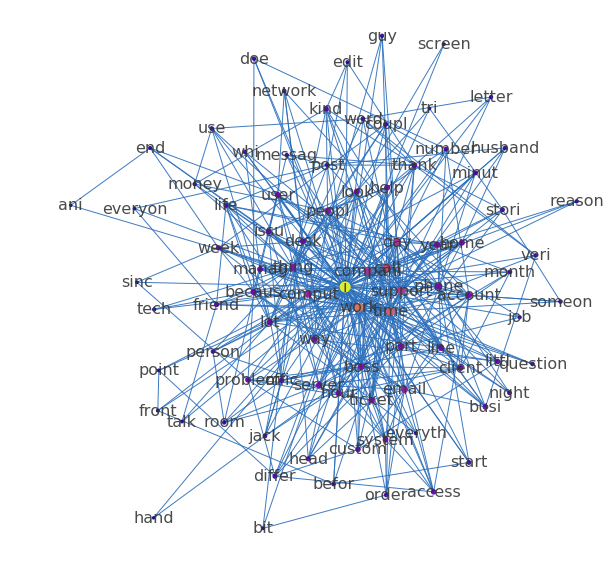

In [225]:
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

That is an interesting pattern; everyone is talking about themselves ("I...this", "I...that").

What if we want to look at noun-verb pairs instead?

In [226]:
gNV = posCooccurrence(redditTopScores['normalized_sents'].sum(), 'NN', 'VB')

`gNV` has co-occurrences between nouns and nouns as well as between verbs and verbs. Let's remove these and make it purely about noun and verb combinations:

In [227]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 2871
Number of edges: 40613
Average degree:  28.2919


In [228]:
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if gNV.nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])

In [229]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 2871
Number of edges: 13366
Average degree:   9.3110


Dropping low weight edges and low degree vertices gives us:

In [230]:
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 2])
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 5])

In [231]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 82
Number of edges: 450
Average degree:  10.9756


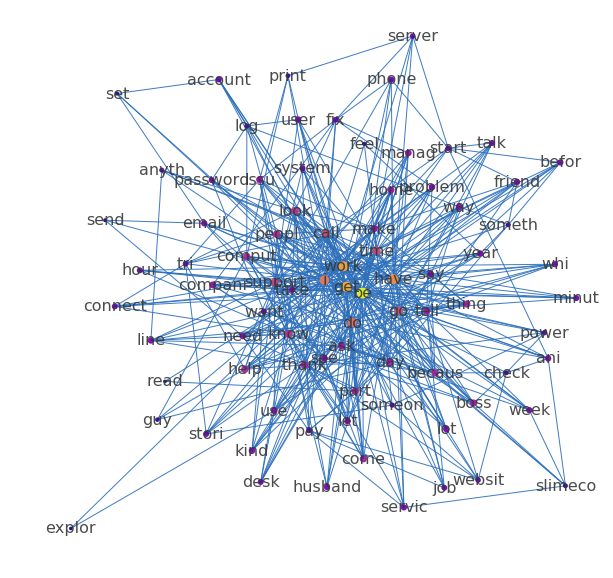

In [232]:
layout_nn = nx.spring_layout(gNV, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNV)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV.edges(data = True)))
nx.draw(gNV, ax = ax, pos = layout_nn, labels = {n: n for n in gNV.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

Lets create an "ego network" surrounding a single (important) word, as we did before:

In [233]:
g_i = gNV.subgraph(['i'] + list(gNV.neighbors('i')))

In [234]:
print(nx.info(g_i))

Name: 
Type: SubGraph
Number of nodes: 34
Number of edges: 33
Average degree:   1.9412


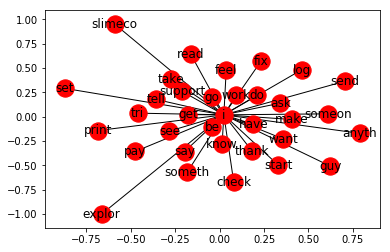

In [235]:
nx.draw_networkx(g_i)

Instead of just nodes connected to a vertex, we can find all those connected to it within 2 hops, lets look at 'stori' for this:

In [236]:
storyNeighbors = gNV.neighbors('stori')
set(storyNeighbors)

{'be', 'get', 'know', 'someon', 'support', 'thank', 'tri'}

In [237]:
storyNeighbors = set(gNV.neighbors('stori'))
storyNeighborsPlus1 = set(storyNeighbors)
for n in storyNeighbors:
    storyNeighborsPlus1 |= set(gNV.neighbors(n))

In [238]:
gNV_story = gNV.subgraph(storyNeighborsPlus1)
print(nx.info(gNV_story))

Name: 
Type: SubGraph
Number of nodes: 56
Number of edges: 161
Average degree:   5.7500


This is a mid-sized network, but we can interrogate it intelligently by computing some statistics. Degree centrality:

In [239]:
sorted(nx.degree_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('be', 0.8727272727272727),
 ('get', 0.7090909090909091),
 ('support', 0.39999999999999997),
 ('know', 0.36363636363636365),
 ('thank', 0.3090909090909091),
 ('tri', 0.14545454545454545),
 ('stori', 0.12727272727272726),
 ('i', 0.12727272727272726),
 ('call', 0.12727272727272726),
 ('someon', 0.12727272727272726)]

Or eigenvector centrality:

In [240]:
sorted(nx.eigenvector_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('be', 0.43928984202898524),
 ('get', 0.3826631410829016),
 ('support', 0.24421847103891114),
 ('know', 0.21111457825779464),
 ('thank', 0.19442994690119703),
 ('stori', 0.15627933587529896),
 ('i', 0.15627933587529896),
 ('call', 0.15627933587529896),
 ('issu', 0.14825532139380798),
 ('help', 0.14825532139380798)]

Notice that 'stori' isn't even in the top 5:

Lets plot it:

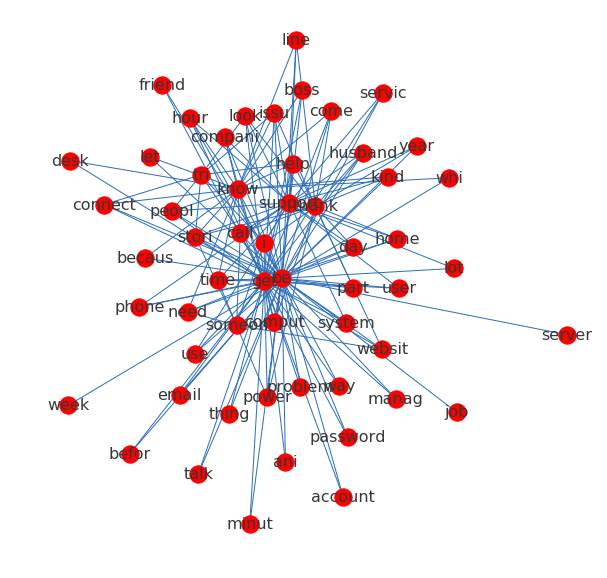

In [241]:
layout_story = nx.spring_layout(gNV_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_story, ax = ax, pos = layout_story, labels = {n: n for n in gNV_story.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

"I" is still in the middle. These are stories about the self.

Lets create a noun-adjective network:

In [242]:
gNJ = posCooccurrence(redditTopScores['normalized_sents'][:100].sum(), 'NN', 'JJ')
print(nx.info(gNJ))

Name: 
Type: Graph
Number of nodes: 3114
Number of edges: 42801
Average degree:  27.4894


By filtering by a centrality measure we can get a more 'central' set of nodes instead of just the most connected.

In [243]:
gNJ_filtered200 = filterWords(gNJ, minWeight=3, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(gNJ_filtered200))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 74
Average degree:   5.9200


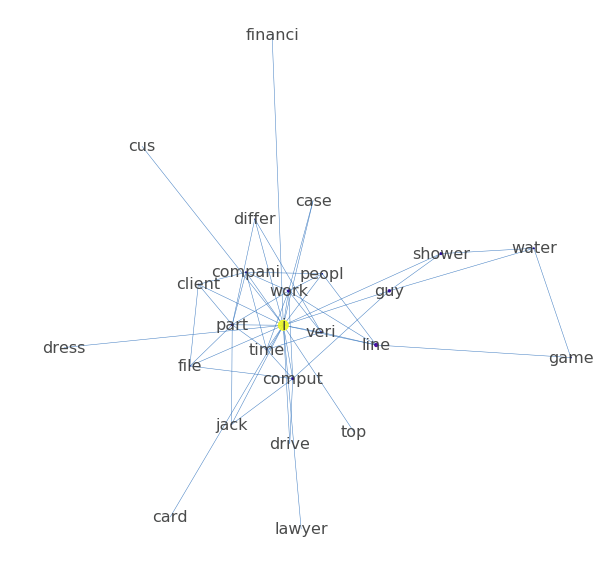

In [244]:
layout_NJ_filtered200 = nx.spring_layout(gNJ_filtered200, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj200 = nx.betweenness_centrality(gNJ_filtered200)
maxC = max(centralities_nj200.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_filtered200, ax = ax, pos = layout_NJ_filtered200, labels = {n: n for n in gNJ_filtered200.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nj200[n] / maxC for n in gNJ_filtered200.nodes],
        node_size = [centralities_nj200[n] / maxC * 100 for n in gNJ_filtered200.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

A truly self-centered network.

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that construct at least two different networks comprising different combinations of word types, linked by different syntactic structures, which illuminate your corpus and the dynamics you are interested to explore. Graph these networks or subnetworks within them. What are relationships that are meaningful? 

<span style="color:red">***Stretch***: Graph some word-centered "ego-networks" with words one link away, two links away, and three links away (we only did up to two links away above).

First let's see what are the network of nouns in my data.

In [256]:
gNN_plots = posCooccurrence(plots['normalized_sents'].sum(), 'NN')

In [257]:
print(nx.info(gNN_plots))

Name: 
Type: Graph
Number of nodes: 3764
Number of edges: 43930
Average degree:  23.3422


In [258]:
gNN_plots.remove_nodes_from([n for n in gNN_plots.nodes if len(set(gNN_plots.neighbors(n))) <= 100]) 
print(nx.info(gNN_plots))

Name: 
Type: Graph
Number of nodes: 134
Number of edges: 2904
Average degree:  43.3433


In [259]:
gNN_plots.remove_edges_from([(n1, n2) for n1, n2, d in gNN_plots.edges(data = True) if d['weight'] <= 1])
print(nx.info(gNN_plots))

Name: 
Type: Graph
Number of nodes: 134
Number of edges: 948
Average degree:  14.1493


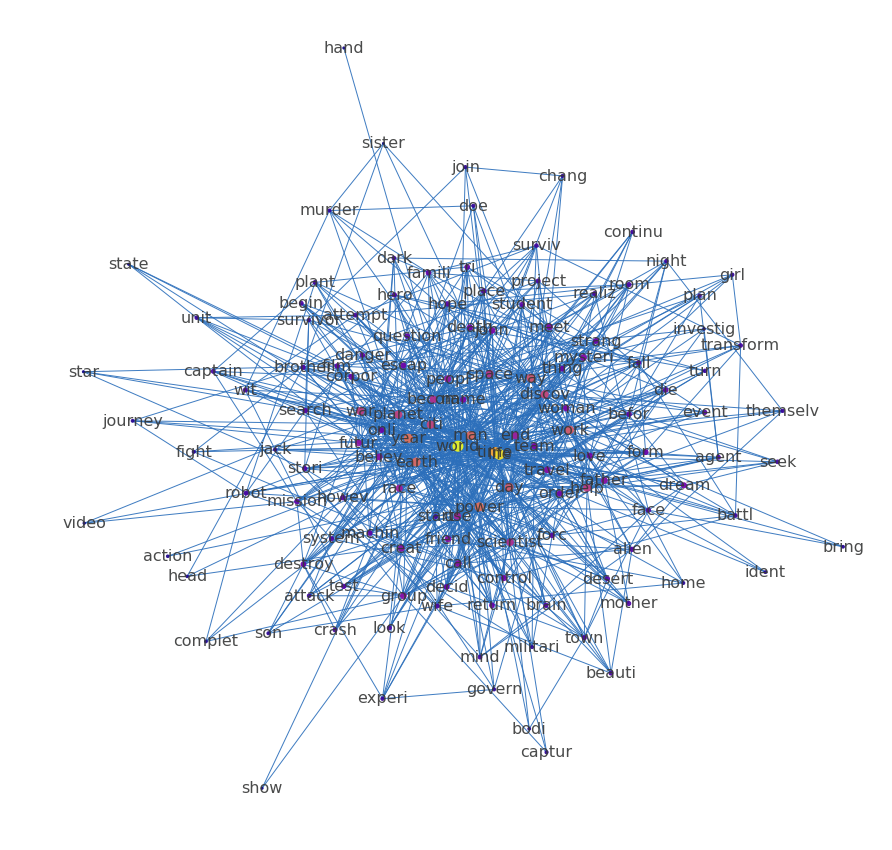

In [262]:
layout_nn_plots = nx.spring_layout(gNN_plots, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (15,15))
centralities_nn_plots = nx.eigenvector_centrality(gNN_plots)
maxC = max(centralities_nn_plots.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN_plots.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN_plots.edges(data = True)))
nx.draw(gNN_plots, ax = ax, pos = layout_nn_plots, labels = {n: n for n in gNN_plots.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN_plots.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn_plots[n] / maxC for n in gNN_plots.nodes],
        node_size = [centralities_nn_plots[n] / maxC * 100 for n in gNN_plots.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

The nouns identified at the center are again, very broad concepts, such as "life", "time", "world", "man", "year", "earth", "power", "day", "work", etc. These clarify the main concept of sci-fi movies, which is about mankind and the world, instead of individuals.

Then let's look at noun-verb pairs.

In [353]:
gNV_plots = posCooccurrence(plots['normalized_sents'].sum(), 'NN', 'VB')
print(nx.info(gNV_plots))

Name: 
Type: Graph
Number of nodes: 3821
Number of edges: 47970
Average degree:  25.1086


In [354]:
gNV_plots.remove_edges_from([(n1,n2) for n1,n2,d in gNV_plots.edges(data = True) if gNV_plots.nodes[n1]['bipartite'] == gNV_plots.nodes[n2]['bipartite']])
print(nx.info(gNV_plots))

Name: 
Type: Graph
Number of nodes: 3821
Number of edges: 3353
Average degree:   1.7550


In [355]:
#gNV_plots.remove_edges_from([(n1, n2) for n1, n2, d in gNV_plots.edges(data = True) if d['weight'] <= 1])
gNV_plots.remove_nodes_from([n for n in gNV_plots.nodes if len(set(gNV_plots.neighbors(n))) <= 10])
print(nx.info(gNV_plots))

Name: 
Type: Graph
Number of nodes: 86
Number of edges: 332
Average degree:   7.7209


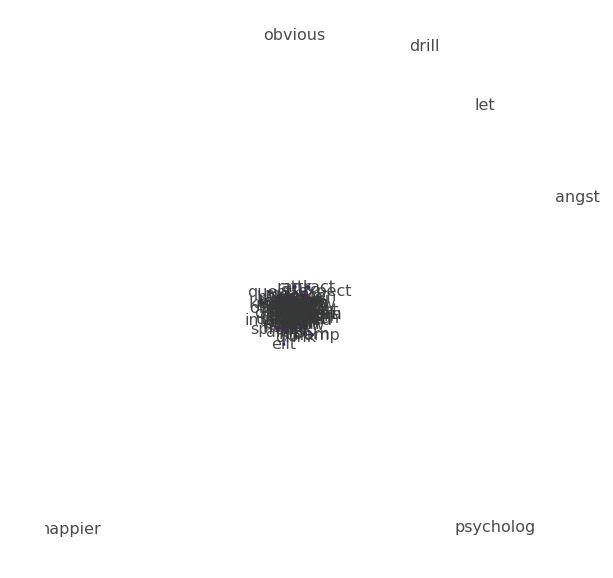

In [356]:
layout_nv_plots = nx.spring_layout(gNV_plots, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv_plots = nx.eigenvector_centrality(gNV_plots)
maxC = max(centralities_nv_plots.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV_plots.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV_plots.edges(data = True)))
nx.draw(gNV_plots, ax = ax, pos = layout_nv_plots, labels = {n: n for n in gNV_plots.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN_plots.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv_plots[n] / maxC for n in gNV_plots.nodes],
        node_size = [centralities_nv_plots[n] / maxC * 100 for n in gNV_plots.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

Let's create an "ego network" surrounding the word "world".

In [357]:
g_world = gNV_plots.subgraph(['world'] + list(gNV_plots.neighbors('world')))
print(nx.info(g_world))

Name: 
Type: SubGraph
Number of nodes: 24
Number of edges: 23
Average degree:   1.9167


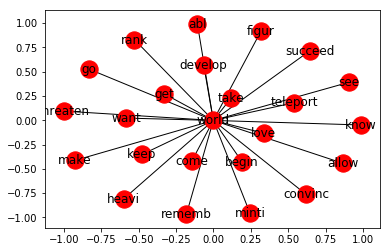

In [358]:
nx.draw_networkx(g_world)

It seems that people are still quite positive about the world! Maybe movies are meant to support, encourage and cheer people up.

Let's find all those connected to the word "world" within 2 hops.

In [359]:
worldNeighbors = gNV_plots.neighbors('world')
set(worldNeighbors)

{'abl',
 'allow',
 'begin',
 'come',
 'convinc',
 'develop',
 'figur',
 'get',
 'go',
 'heavi',
 'keep',
 'know',
 'love',
 'make',
 'minti',
 'rank',
 'rememb',
 'see',
 'succeed',
 'take',
 'teleport',
 'threaten',
 'want'}

In [360]:
worldNeighbors = set(gNV_plots.neighbors('world'))
worldNeighborsPlus1 = set(worldNeighbors)
for n in worldNeighbors:
    worldNeighborsPlus1 |= set(gNV_plots.neighbors(n))
worldNeighborsPlus1

{'abl',
 'allow',
 'becom',
 'begin',
 'come',
 'convinc',
 'day',
 'develop',
 'discov',
 'doe',
 'dream',
 'earth',
 'famili',
 'figur',
 'friend',
 'get',
 'go',
 'heavi',
 'help',
 'keep',
 'know',
 'life',
 'love',
 'make',
 'man',
 'minti',
 'mission',
 'order',
 'peopl',
 'planet',
 'plant',
 'power',
 'rank',
 'rememb',
 'see',
 'space',
 'succeed',
 'take',
 'teleport',
 'threaten',
 'time',
 'use',
 'want',
 'way',
 'woman',
 'work',
 'world',
 'year'}

In [361]:
gNV_world = gNV_plots.subgraph(worldNeighborsPlus1)
print(nx.info(gNV_world))

Name: 
Type: SubGraph
Number of nodes: 48
Number of edges: 201
Average degree:   8.3750


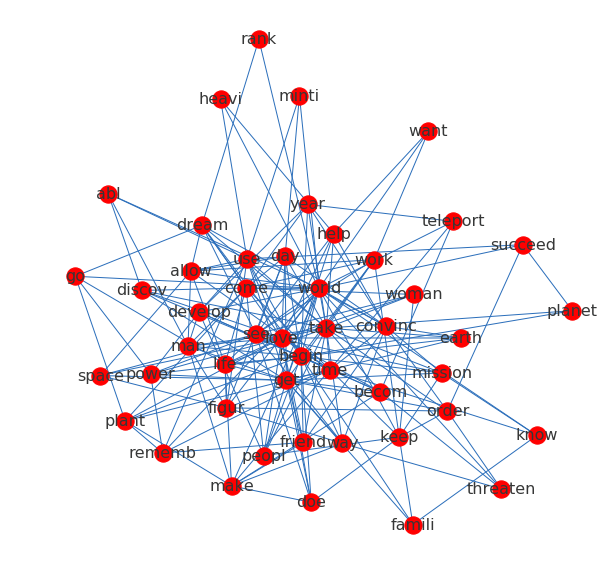

In [362]:
layout_world = nx.spring_layout(gNV_world, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_world, ax = ax, pos = layout_world, labels = {n: n for n in gNV_world.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       )

Still, it seems that almost all the words associated with "world" are positive or at least neutral, such as "dream", "allow", "develop", "power", "love", "begin", "succeed", etc.

Let's find all those connected to the word "world" within 3 hops.

In [370]:
worldNeighborsPlus2 = set(worldNeighborsPlus1)
for n in worldNeighborsPlus1:
    worldNeighborsPlus2 |= set(gNV_plots.neighbors(n))
worldNeighborsPlus2

{'abl',
 'adequ',
 'aliv',
 'allow',
 'articl',
 'attract',
 'becom',
 'begin',
 'champ',
 'chilli',
 'come',
 'convinc',
 'cope',
 'day',
 'develop',
 'discov',
 'doe',
 'dream',
 'drink',
 'earn',
 'earth',
 'elit',
 'eve',
 'expect',
 'famili',
 'figur',
 'follow',
 'friend',
 'get',
 'give',
 'go',
 'guid',
 'handl',
 'happen',
 'heavi',
 'help',
 'hibern',
 'imagin',
 'keep',
 'key',
 'know',
 'life',
 'listen',
 'lose',
 'love',
 'make',
 'man',
 'mar',
 'mean',
 'minti',
 'mission',
 'obtain',
 'order',
 'pay',
 'peopl',
 'planet',
 'plant',
 'power',
 'quest',
 'rank',
 'rememb',
 'see',
 'send',
 'space',
 'sprinkl',
 'succeed',
 'switch',
 'take',
 'teleport',
 'threaten',
 'time',
 'untangl',
 'use',
 'walk',
 'want',
 'way',
 'woman',
 'work',
 'world',
 'year'}

In [371]:
gNV_world = gNV_plots.subgraph(worldNeighborsPlus2)
print(nx.info(gNV_world))

Name: 
Type: SubGraph
Number of nodes: 80
Number of edges: 332
Average degree:   8.3000


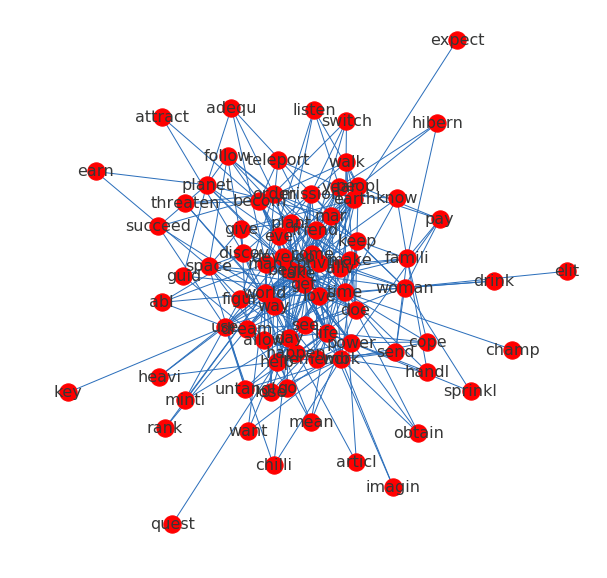

In [372]:
layout_world = nx.spring_layout(gNV_world, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_world, ax = ax, pos = layout_world, labels = {n: n for n in gNV_world.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       )

Even words with 3 links about "world" are almost all positive and neutral!

Let's create a noun-adjective network:

In [376]:
gNJ_plots = posCooccurrence(plots['normalized_sents'][:100].sum(), 'NN', 'JJ')
print(nx.info(gNJ_plots))

Name: 
Type: Graph
Number of nodes: 1847
Number of edges: 17932
Average degree:  19.4174


In [377]:
gNJ_filtered_plots = filterWords(gNJ_plots, minWeight=1, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(gNJ_filtered_plots))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 139
Average degree:  11.1200


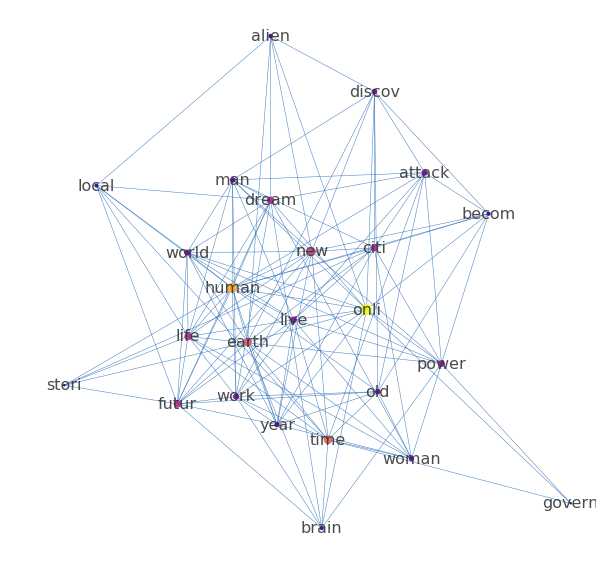

In [378]:
layout_NJ_filtered_plots = nx.spring_layout(gNJ_filtered_plots, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj_plots = nx.betweenness_centrality(gNJ_filtered_plots)
maxC = max(centralities_nj_plots.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_filtered_plots, ax = ax, pos = layout_NJ_filtered_plots, labels = {n: n for n in gNJ_filtered_plots.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nj_plots[n] / maxC for n in gNJ_filtered_plots.nodes],
        node_size = [centralities_nj_plots[n] / maxC * 100 for n in gNJ_filtered_plots.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

It seems that "world" is no longer at the very center, instead, "online" is in the center. The sci-fi movies in this period is mainly about the Internet world! Overall, the words about "online", "human", "live" are still positive or neutral. 

Combined with the findings from previous exercises, we can see that the sci-fi movies in this period are caring about the fate of human beings, and people are quite positive about it. It seems that people are seeking or experiencing success in movies. Movies in this period are not a mirror of the relaity, but a utopia world.

# Interactional influence

In a recent paper by Fangjian Guo, Charles Blundell, Hanna Wallach, and Katherine Heller entitled ["The Bayesian Echo Chamber: Modeling Social Influence via Linguistic Accommodation"](https://arxiv.org/pdf/1411.2674.pdf), the authors develop a method to estimate the influence of one speaker on another in order to estimate a kind of interpersonal influence network. Here we walk through this method, which relies on a kind of point process called a Hawkes process that estimate the influence of one point on another. Specifically, what they estimate is the degree to which one actor to an interpersonal interaction engaged in "accomodation" behaviors relative to the other, generating a directed edge from the one to the other.

### First let's look at the output of their analysis:

In [379]:
example_name = '12-angry-men'   #example datasets: "12-angry-men" or "USpresident"

In [380]:
result_path = '../data/Bayesian-echo/results/{}/'.format(example_name)
if not os.path.isdir(result_path):
    raise ValueError('Invalid example selected, only "12-angry-men" or "USpresident" are avaliable')

In [381]:
df_meta_info = pandas.read_table(result_path + 'meta-info.txt',header=None)
df_log_prob = pandas.read_csv(result_path + "SAMPLE-log_prior_and_log_likelihood.txt",delim_whitespace=True) #log_prob samples
df_influence = pandas.read_csv(result_path + 'SAMPLE-influence.txt',delim_whitespace=True) # influence samples
df_participants = pandas.read_csv(result_path + 'cast.txt', delim_whitespace=True)
person_id = pandas.Series(df_participants['agent.num'].values-1,index=df_participants['agent.name']).to_dict()
print()
print ('Person : ID')
person_id


Person : ID


{'Foreman': 3,
 'Juror 10': 2,
 'Juror 11': 6,
 'Juror 12': 7,
 'Juror 2': 9,
 'Juror 3': 1,
 'Juror 4': 5,
 'Juror 5': 11,
 'Juror 6': 8,
 'Juror 7': 4,
 'Juror 8': 0,
 'Juror 9': 10}

In [382]:
def getDensity(df):
    data = df#_log_prob['log.prior']
    density = scipy.stats.gaussian_kde(data)
    width = np.max(data) - np.min(data)
    xs = np.linspace(np.min(data)-width/5, np.max(data)+width/5,600)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    return xs, density(xs)

### Plot MCMC (Markov Monte Carlo) trace and the density of log-likelihoods

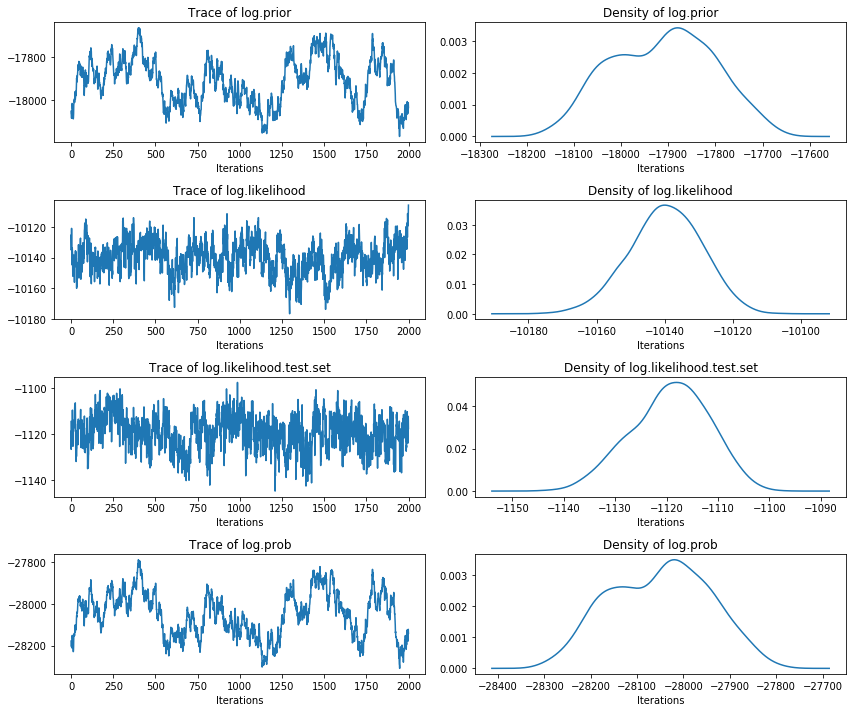

In [383]:
fig = plt.figure(figsize=[12,10])

plt.subplot(4,2,1)
plt.plot(df_log_prob['log.prior'])
plt.xlabel('Iterations')
plt.title('Trace of log.prior')

plt.subplot(4,2,2)
x,y = getDensity(df_log_prob['log.prior'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prior')

plt.subplot(4,2,3)
plt.plot(df_log_prob['log.likelihood'])
plt.title('Trace of log.likelihood')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,4)
x,y = getDensity(df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood')

plt.subplot(4,2,5)
plt.plot(df_log_prob['log.likelihood.test.set'])
plt.title('Trace of log.likelihood.test.set')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,6)
x,y = getDensity(df_log_prob['log.likelihood.test.set'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood.test.set')

plt.subplot(4,2,7)
plt.plot(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.title('Trace of log.prob')
plt.xlabel('Iterations')

plt.subplot(4,2,8)
x,y = getDensity(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prob')

plt.tight_layout()

plt.show()

### Plot the influence matrix between participants

In [384]:
A = int(np.sqrt(len(df_influence.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

In [385]:
def getmatrix(stacked,A):
    influence_matrix = [[0 for i in range(A)] for j in range(A)]
    for row in stacked.iteritems():
        from_ = int(row[0].split('.')[1])-1
        to_ = int(row[0].split('.')[2])-1
        value = float(row[1])
        influence_matrix[from_][to_]=value
    df_ = pandas.DataFrame(influence_matrix) 
    
    df_ =df_.rename(index = id_person)
    df_ =df_.rename(columns = id_person)
    return df_

In [386]:
stacked = df_influence.mean(axis=0)
df_mean = getmatrix(stacked,A)

stacked = df_influence.std(axis=0)
df_std = getmatrix(stacked,A)

In [387]:
df_mean

Juror 8   Juror 3  Juror 10   Foreman   Juror 7   Juror 4  \
Juror 8   0.000000  3.757957  8.089079  0.930180  5.167497  0.794645   
Juror 3   8.529312  0.000000  6.673916  4.150076  2.534751  4.902852   
Juror 10  8.413188  7.427932  0.000000  4.540236  3.216307  1.030049   
Foreman   1.137060  0.612615  1.945196  0.000000  1.521390  0.834870   
Juror 7   2.603853  5.901169  0.648844  1.969868  0.000000  1.110101   
Juror 4   5.791320  0.200669  0.266484  0.582956  0.094200  0.000000   
Juror 11  0.378515  0.544628  0.779340  0.454645  0.290575  0.447512   
Juror 12  5.961338  0.695831  0.519459  1.253033  0.247939  0.162463   
Juror 6   4.526244  0.923784  0.503503  1.049825  1.288920  0.451562   
Juror 2   0.583732  2.303417  0.529583  1.722894  2.005939  0.299311   
Juror 9   1.216641  1.281288  0.967587  1.675483  1.657341  1.681338   
Juror 5   0.552951  1.001575  0.696393  1.180245  1.180355  0.497265   

          Juror 11  Juror 12   Juror 6   Juror 2   Juror 9   Juror 5  
Juror 8   0.845335  1.336329  6.106684  0.916765  6.385205  7.300776  
Juror 3   1.092571  0.509942  3.825015  3.861767  0.266426  1.561626  
Juror 10  1.004598  0.529232  2.426582  0.407460  1.233599  0.885871  
Foreman   1.338554  3.230634  1.013511  3.534036  1.311436  4.115411  
Juror 7   0.279870  0.608548  1.047693  2.910670  1.619475  1.570038  
Juror 4   3.347982  0.316963  0.300770  2.112033  0.370973  0.673364  
Juror 11  0.000000  0.614536  0.821143  0.951222  0.476986  0.844157  
Juror 12  0.388620  0.000000  2.500976  2.375977  0.481394  0.834032  
Juror 6   0.375776  0.904313  0.000000  2.861587  0.905421  0.310822  
Juror 2   0.652302  1.623813  0.841376  0.000000  1.691612  1.756225  
Juror 9   0.623032  1.925996  1.907992  0.539666  0.000000  1.138934  
Juror 5   0.786181  0.588822  0.724613  0.912616  1.224854  0.000000

MEAN of influence matrix (row=from, col=to)


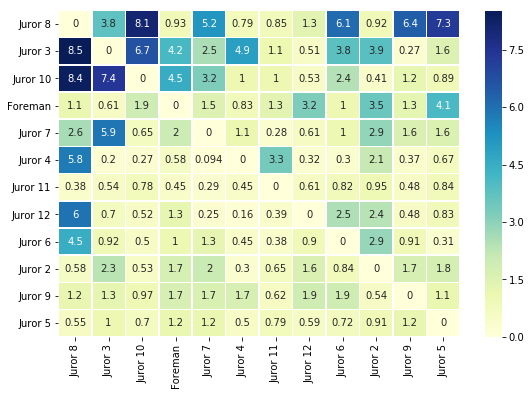

In [388]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_mean, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('MEAN of influence matrix (row=from, col=to)')
plt.show()

SD of influence matrix (row=from, col=to)


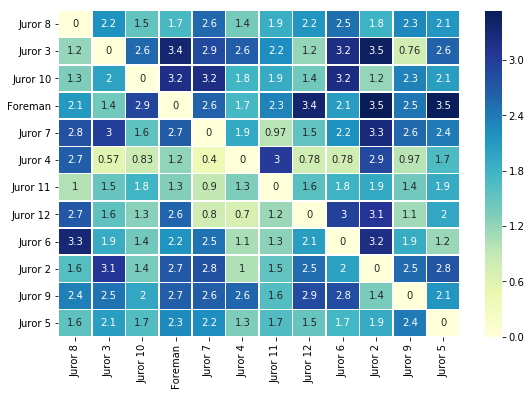

In [389]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_std, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('SD of influence matrix (row=from, col=to)')
plt.show()

### Barplot of total influences sent/received

In [390]:
sender_std = {} #sd of total influence sent
reciever_std = {} #sd of total influence recieved
for i in range(A):
    reciever_std[id_person[i]] = df_influence[df_influence.columns[i::A]].sum(axis=1).std()
    sender_std[id_person[i]] = df_influence[df_influence.columns[i*A:(i+1)*A:]].sum(axis=1).std()

sent = df_mean.sum(axis=1) #mean of total influence sent
recieved =df_mean.sum(axis=0) #mean of total influence recieved

Total influence:

		Total linguistic influence sent/received 


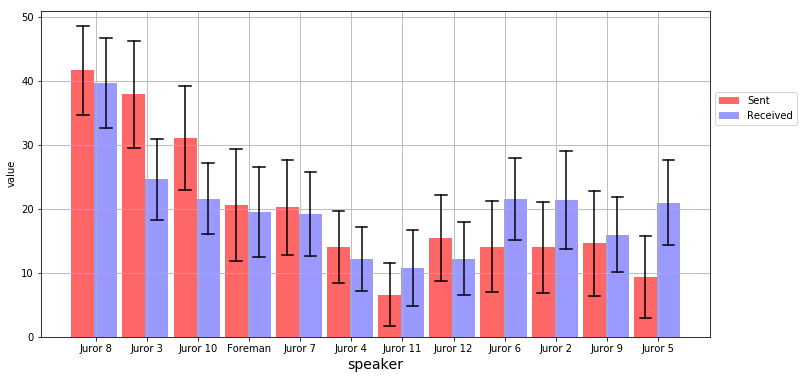

In [391]:
print ("\t\tTotal linguistic influence sent/received ")
ax.fig = plt.figure(figsize=[np.min([A,20]),6])

plt.grid()
wd=0.45
ii=0
for p in sender_std:
    plt.bar(person_id[p],sent.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]+sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]-sender_std[p],sent.loc[p]-sender_std[p]],color='k')
    plt.plot([person_id[p],person_id[p]],[sent.loc[p]-sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    ii+=1
ii=0
for p in reciever_std:
    plt.bar(person_id[p]+wd,recieved.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]+reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]-reciever_std[p],recieved.loc[p]-reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd,person_id[p]+wd],[recieved.loc[p]-reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i+0.25 for i in range(A)],list(zip(*sorted(id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

## Visualize Influence Network!

You can visualize any of the influence matrices above:

Using networkx:

In [392]:
def drawNetwork(df,title):
    fig = plt.figure(figsize=[8,8])
    G = nx.DiGraph()
    for from_ in df.index:
        for to_ in df.columns:
            G.add_edge(from_,to_,weight = df.loc[from_][to_])
            
    pos = nx.spring_layout(G,k=0.55,iterations=20)
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = np.array(weights)
    #weights = weights*weights
    weights = 6*weights/np.max(weights)
    print(title)
    
    edge_colors=20*(weights/np.max(weights))
    edge_colors = edge_colors.astype(int)
#     nx.draw_networkx_nodes(G,pos,node_size=1200,alpha=0.7,node_color='#99cef7')
#     nx.draw_networkx_edges(G,pos,edge_color=edge_colors)
#     nx.draw_networkx_labels(G,pos,font_weight='bold')
    nx.draw(G,pos,with_labels=True, font_weight='bold',width=weights,\
            edge_color=255-edge_colors,node_color='#99cef7',node_size=1200,\
            alpha=0.75,arrows=True,arrowsize=20)
    return edge_colors

In [393]:
# get quantile influence matrices for 25%, 50%, 75% quantile
stacked = df_influence.quantile(0.25)
df_q25 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.5)
df_q50 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.75)
df_q75 = getmatrix(stacked,A)

Mean Influence Network


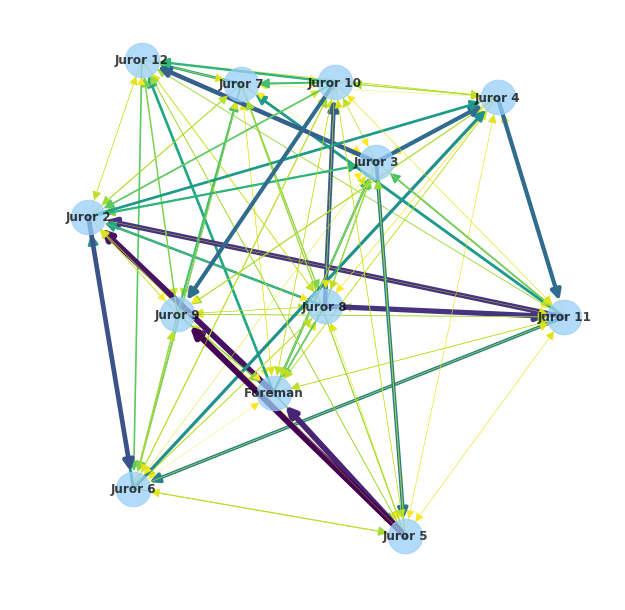

In [394]:
G_mean = drawNetwork(df_mean,'Mean Influence Network')

25 Quantile Influence Network


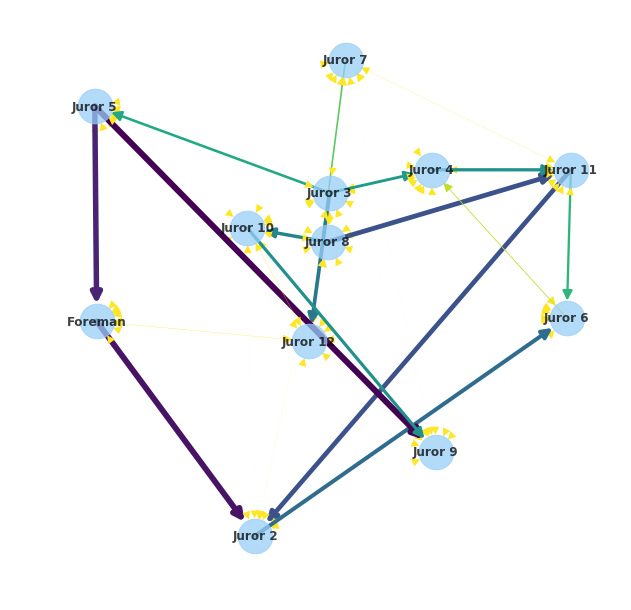

In [395]:
G_q25 = drawNetwork(df_q25,'25 Quantile Influence Network')

75 Quantile Influence Network


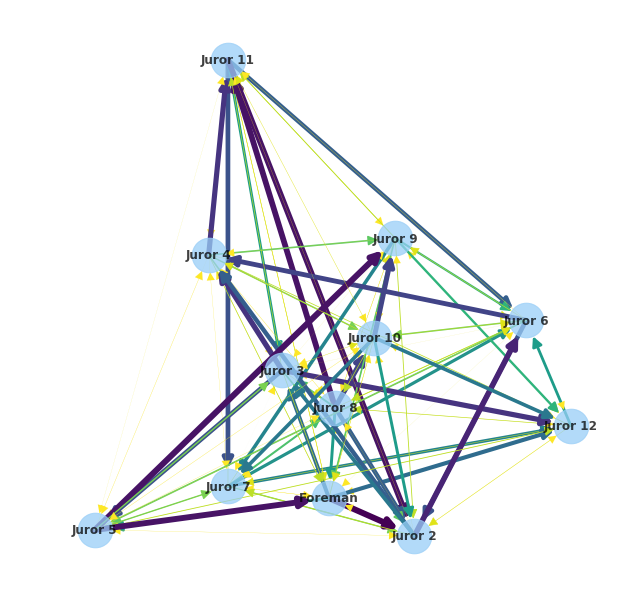

In [396]:
G_q75 = drawNetwork(df_q75,'75 Quantile Influence Network')

In [397]:
import lucem_illud
import pandas
def fakeEnglish(length):
    listd=['a','b','c','d','e','f','g','s','h','i','j','k','l']
    return ''.join(np.random.choice(listd,length))

Your own dataset should contains 4 columns (with the same column names) as the artificial one below:

- name: name of the participant
- tokens: a list of tokens in one utterance
- start: starting time of utterance (unit doesn't matter, can be 'seconds','minutes','hours'...)
- end: ending time of utterance (same unit as start)

There is no need to sort data for the moment.

Below, we generate a fake collection of data from "Obama", "Trump", "Clinton"...and other recent presidents. You can either create your own simulation OR (better), add real interactional data from a online chat forum, comment chain, or transcribed from a conversation.

In [398]:
script= []
language = 'eng' #parameter, no need to tune if using English, accept:{'eng','chinese'}
role = 'Adult' #parameter, no need to tune 

for i in range(290):
    dt = []
    dt.append(np.random.choice(['Obama','Trump','Clinton','Bush','Reagan','Carter','Ford','Nixon','Kennedy','Roosevelt']))
    faketokens = [fakeEnglish(length = 4) for j in range(30)]
    dt.append(faketokens) #fake utterance
    dt.append(i*2+np.random.random()) # start time
    dt.append(i*2+1+np.random.random()) # end time
    script.append(dt)

df_transcript = pandas.DataFrame(script,columns=['name','tokens','start','end']) #"start", "end" are timestamps of utterances, units don't matter
df_transcript[:2]

name                                             tokens     start  \
0   Obama  [fkfi, kcki, fbig, kbdc, bcfg, bhes, dejd, djd...  0.064743   
1  Reagan  [egfh, ghkc, celh, dlei, bhdb, afej, igje, dhl...  2.693504   

        end  
0  1.186616  
1  3.002487

Transform data into TalkbankXML format:

In [399]:
output_fname = 'USpresident.xml'  #should be .xml
language = 'eng' 
#language = 'chinese'
lucem_illud.make_TalkbankXML(df_transcript, output_fname, language = language )

New File saved to ./data/USpresident/USpresident.xml


0

Run Bayesian Echo Chamber to get estimation.

- It may take a couple of hours. ( About 4-5 hours if Vocab_size=600 and sampling_time =2000)
- Larger "Vocab_size" (see below) will cost more time
- Larger "sampling_time" will also consume more time

In [400]:
Vocab_size = 90 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
lucem_illud.bec_run(output_fname, Vocab_size, language, sampling_time)

Realtime output can be viewed in shell.

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that either (1) take data from a transcribed conversation, online chat forum, comment chain or some other *timed* interaction and calculate Bayesian influence; or (2) build a simulation similar in spirit to the "Presidents" example above, ideally infusing it with interesting "stylized facts". What does that estimation and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?

For this exercise I downloaded the corpus that contains a collection of conversations from the U.S. Supreme Court Oral Arguments with 51,498 utterances making up 50,389 conversational exchanges from 204 cases involving 11 Justices and 311 other participants (lawyers or amici curiae).

In [406]:
col_names=['case_id','utterance_id','after_previous','name','is_justice','justice_vote','presentation_side','utterance']
df_conversations = pandas.read_csv('supreme_conversations.txt', sep='\++\$\++', header=None, names=col_names)
df_conversations = df_conversations[['name', 'utterance']]
df_conversations[:5]

/Users/yiqingzhu/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  from ipykernel import kernelapp as app


name                                          utterance
0    JUSTICE STEVENS    We will now hear argument in the Cherokee Nat...
1         MR. MILLER    Justice Stevens, and may it please the Court:...
2   JUSTICE O'CONNOR    Would you mind explaining to us how these two...
3         MR. MILLER    No, Justice O'Connor. They're -- they're not ...
4   JUSTICE O'CONNOR    But they're certainly at odds on the legal th...

In [407]:
for index, row in df_conversations.iterrows():
    df_conversations.set_value(index,'start',np.random.random())
    df_conversations.set_value(index,'end',1+np.random.random())

In [408]:
df_conversations['tokens'] = df_conversations['utterance'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
df_conversations[:5]

name                                          utterance  \
0    JUSTICE STEVENS    We will now hear argument in the Cherokee Nat...   
1         MR. MILLER    Justice Stevens, and may it please the Court:...   
2   JUSTICE O'CONNOR    Would you mind explaining to us how these two...   
3         MR. MILLER    No, Justice O'Connor. They're -- they're not ...   
4   JUSTICE O'CONNOR    But they're certainly at odds on the legal th...   

      start       end                                             tokens  
0  0.011813  1.487807  [[We, will, now, hear, argument, in, the, Cher...  
1  0.016625  1.797277  [[Justice, Stevens, ,, and, may, it, please, t...  
2  0.414651  1.463141  [[Would, you, mind, explaining, to, us, how, t...  
3  0.380294  1.197871  [[No, ,, Justice, O'Connor, .], [They, 're, --...  
4  0.907401  1.158220  [[But, they, 're, certainly, at, odds, on, the...

In [409]:
df_conversations_small = df_conversations[:300]

In [410]:
output_fname_conversation = 'USsupreme.xml'  #should be .xml
language = 'eng'
#language = 'chinese'
lucem_illud.make_TalkbankXML(df_conversations_small, output_fname_conversation, language = language)

New File saved to ./data/USsupreme/USsupreme.xml


/Users/yiqingzhu/anaconda/lib/python3.5/site-packages/lucem_illud/bayesian.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['start'] = df['start'].apply(pd.to_numeric)
/Users/yiqingzhu/anaconda/lib/python3.5/site-packages/lucem_illud/bayesian.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['end'] = df['end'].apply(pd.to_numeric)


0

In [411]:
Vocab_size = 50 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
lucem_illud.bec_run(output_fname_conversation, Vocab_size, language, sampling_time)

In [415]:
df_influence_supreme = pandas.read_csv('./results/USsupreme/SAMPLE-influence.txt',delim_whitespace=True) # influence samples

In [416]:
df_participants_supreme = pandas.read_csv('./results/USsupreme/cast.txt', delim_whitespace=True)
person_id = pandas.Series(df_participants_supreme['agent.num'].values-1,index=df_participants_supreme['agent.name']).to_dict()

In [417]:
A = int(np.sqrt(len(df_influence_supreme.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

In [418]:
stacked = df_influence_supreme.mean(axis=0)
df_mean_supreme = getmatrix(stacked,A)

stacked = df_influence_supreme.std(axis=0)
df_std_supreme = getmatrix(stacked,A)

MEAN of influence matrix (row=from, col=to)


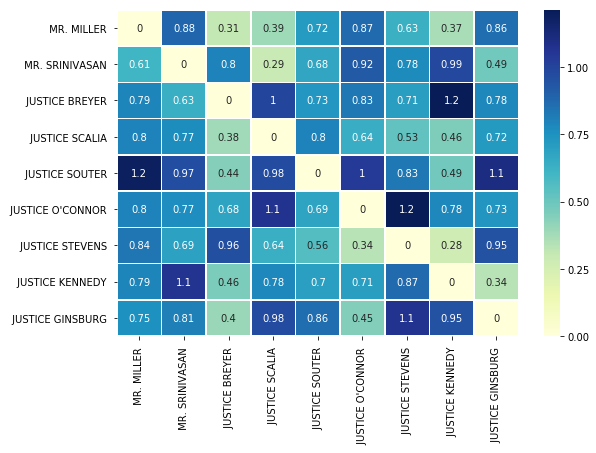

In [419]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_mean_supreme, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('MEAN of influence matrix (row=from, col=to)')
plt.show()

SD of influence matrix (row=from, col=to)


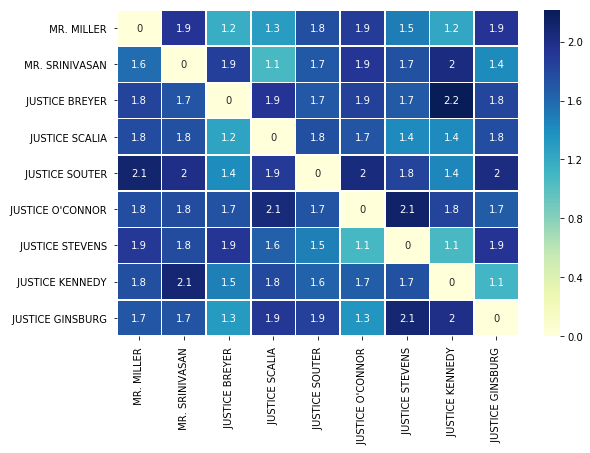

In [420]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_std_supreme, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('SD of influence matrix (row=from, col=to)')
plt.show()

In [421]:
sender_std = {} #sd of total influence sent
reciever_std = {} #sd of total influence recieved
for i in range(A):
    reciever_std[id_person[i]] = df_influence_supreme[df_influence_supreme.columns[i::A]].sum(axis=1).std()
    sender_std[id_person[i]] = df_influence_supreme[df_influence_supreme.columns[i*A:(i+1)*A:]].sum(axis=1).std()

sent_supreme = df_mean_supreme.sum(axis=1) #mean of total influence sent
recieved_supreme =df_mean_supreme.sum(axis=0) #mean of total influence recieved

		Total linguistic influence sent/received 


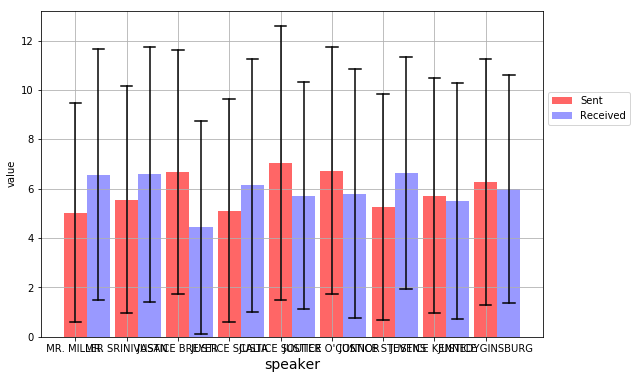

In [422]:
print ("\t\tTotal linguistic influence sent/received ")
ax.fig = plt.figure(figsize=[np.min([A,30]),6])

plt.grid()
wd=0.45
ii=0
for p in sender_std:
    plt.bar(person_id[p],sent_supreme.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent_supreme.loc[p]+sender_std[p],sent_supreme.loc[p]+sender_std[p]],color='k')
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent_supreme.loc[p]-sender_std[p],sent_supreme.loc[p]-sender_std[p]],color='k')
    plt.plot([person_id[p],person_id[p]],[sent_supreme.loc[p]-sender_std[p],sent_supreme.loc[p]+sender_std[p]],color='k')
    ii+=1
ii=0
for p in reciever_std:
    plt.bar(person_id[p]+wd,recieved_supreme.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved_supreme.loc[p]+reciever_std[p],recieved_supreme.loc[p]+reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved_supreme.loc[p]-reciever_std[p],recieved_supreme.loc[p]-reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd,person_id[p]+wd],[recieved_supreme.loc[p]-reciever_std[p],recieved_supreme.loc[p]+reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i for i in range(A)],list(zip(*sorted(id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

In [423]:
# get quantile influence matrices for 25%, 50%, 75% quantile
stacked = df_influence_supreme.quantile(0.25)
df_q25 = getmatrix(stacked,A)

stacked = df_influence_supreme.quantile(0.5)
df_q50 = getmatrix(stacked,A)

stacked = df_influence_supreme.quantile(0.75)
df_q75 = getmatrix(stacked,A)

Mean Influence Network


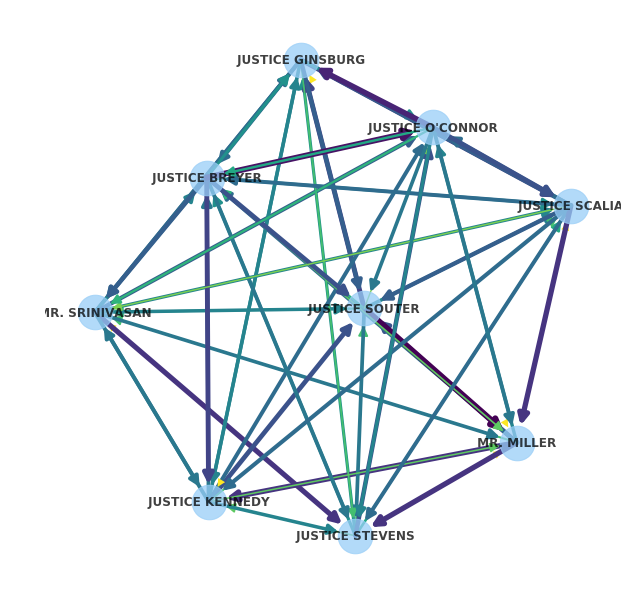

In [424]:
G_mean = drawNetwork(df_mean_supreme,'Mean Influence Network')

25 Quantile Influence Network


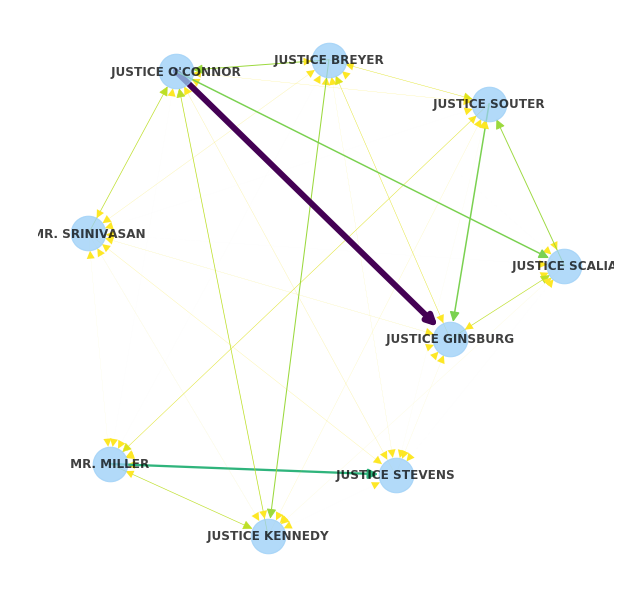

In [425]:
G_q25 = drawNetwork(df_q25,'25 Quantile Influence Network')

75 Quantile Influence Network


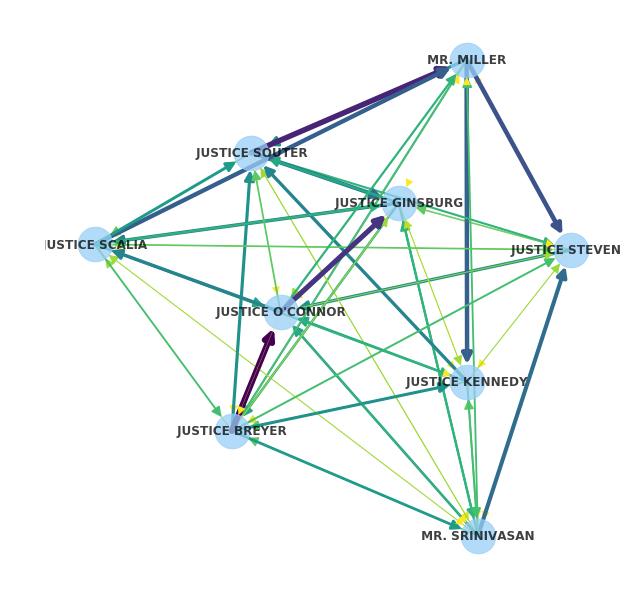

In [426]:
G_q75 = drawNetwork(df_q75,'75 Quantile Influence Network')

From above plots, we can observe the different influence of each speaker in our data. The most interesting difference in influence is between Petitioner Mr. Miller and Respondent Mr. Srinvasan. As we can see, Mr. Miller has averagly higher influence than Mr. Srinvasan, and Mr. Miller strongly influenced Justice Steven and Justice Kennedy, while Mr. Srinvasan was less influential to these two justices. Therefore, from the interactional influence network, we can conclude that Mr. Miller is more influential in this trial than Mr. Srinvasan. By checking the real result of this trial, I found that Mr. Miller did win this case. It seems that the interactional influence network has correctly indicated the result.